# Part 2 Feature Engineering and Modelling

# Library Importing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, f1_score, precision_score, recall_score, accuracy_score
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KernelDensity
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=np.inf)

# Data Import

In [3]:
train = pd.read_csv("./assets/merged_data_clean.csv")
df_test = pd.read_csv("./assets/merged_test_data_clean.csv")
weat = pd.read_csv("./assets/weather_data_clean.csv")
spray = pd.read_csv("./assets/spray_data_clean.csv")

In [4]:
df_train = train.copy()
df_train.columns

Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent', 'year_x', 'month_x', 'Station', 'Tmax',
       'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Sunrise',
       'Sunset', 'CodeSum', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed', 'year_y', 'month_y'],
      dtype='object')

In [5]:
df_test.columns

Index(['Id', 'Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'Station', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Heat',
       'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'PrecipTotal', 'StnPressure',
       'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed', 'year', 'month'],
      dtype='object')

In [6]:
weat.columns

Index(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb',
       'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'PrecipTotal',
       'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed',
       'year', 'month'],
      dtype='object')

# Feature Engineering

## Setting Date as Index

In [7]:
# Setting Date a index for Train Dataset
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_train = df_train.set_index('Date')

In [8]:
# Setting Date a index for Test Dataset
df_test['Date'] = pd.to_datetime(df_test['Date'])
df_test = df_test.set_index('Date')

In [9]:
# Setting Date a index for Spray Dataset
spray['Date'] = pd.to_datetime(spray['Date'])
spray = spray.set_index('Date')

## Setting Tresholds for Condition of Breeding

WNV occurs when there are mosquitos. As mosquitos tend to breed when the weather condition is ideal. At here, we would be setting threshold on the condition of breeding. 

In [10]:
df_train.groupby(['WnvPresent']).mean()['NumMosquitos']

WnvPresent
0    12.106479
1    26.350272
Name: NumMosquitos, dtype: float64

From the datasets, the average number of mosquitos for WNV to be not present is 12.1. With this value, we would be setting the threshold for good condition for mosquito breeding to be 13 mosquitos.
For all rows of data with mosquitos count of over or equal to 13 will be considered as ideal condition for breeding

In [11]:
df_train['BreedCond'] = df_train['NumMosquitos'].apply(lambda x: 1 if x >= 13 else 0)

Spray activity will significantly reduce the number of mosquitoes and disrupt the model prediction. To ensure the model is able to predict the number of mosquito based on weather, dates where spray occured will be remove from the model. 

Also, as effect of spray will last for several days. Assumption of 10 days is made for training model/

## Exclusion of Spray Date from Datasets

As impact of spray lasts for over a day and we assume the impact would be lasting for consecutive days, data that overlaps with the 14 days will be dropped to prevent the Breeding Condition to be affected by the spray.

In [12]:
# To define number of date to be excluded
add_days_ext = [13]

# To loop through the number of days
for day in add_days_ext:
    # To define empty list to store the new dates to be excluded
    exclude_date = []
    # to include the original date in spray date
    day = day + 1
    # to identify the date where spraying occured
    spray_date = spray.index.unique()
    
    # to loop through the individual spray date
    for i in range(len(spray.index.unique())):
        # to loop through the number of days to be excluded
        for j in range(day):
            exclude_date.append(pd.Timestamp(spray_date[i]) + timedelta(days=j))

    print(f'Number of Days to be excluded are: {len(exclude_date)}')

Number of Days to be excluded are: 126


In [13]:
# To remove the dates where spray + 13 days after from the datasets for modeling
df_train = df_train.loc[~df_train.index.isin(exclude_date)]

## Features Selection

In [14]:
df_corr = df_train.copy()

In [15]:
df_corr.columns

Index(['Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent', 'year_x', 'month_x', 'Station', 'Tmax',
       'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Sunrise',
       'Sunset', 'CodeSum', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed', 'year_y', 'month_y',
       'BreedCond'],
      dtype='object')

Dropping features that is categorical datasets or deemed as not useful in identifying the correlation.

In [16]:
df_corr.drop(['Address', 'Block', 'Street', 'AddressNumberAndStreet', 
              'Latitude', 'Longitude', 'AddressAccuracy', 'NumMosquitos', 
               'Station',
              # To be removed below
              'Sunset', 'Sunrise',
              # Categorical datasets
              'CodeSum', 'Species', 'Trap'], axis = 1, inplace = True)

In [17]:
df_corr

,WnvPresent,year_x,month_x,Tmax,Tmin,Tavg,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,year_y,month_y,BreedCond
Date,,,,,,,,,,,,,,,,,,,
2007-05-29,0,2007,5,88,60,74,58,65,0,9,0.0,29.39,30.11,5.8,18,6.5,2007,5,0
2007-05-29,0,2007,5,88,60,74,58,65,0,9,0.0,29.39,30.11,5.8,18,6.5,2007,5,0
2007-05-29,0,2007,5,88,60,74,58,65,0,9,0.0,29.39,30.11,5.8,18,6.5,2007,5,0
2007-05-29,0,2007,5,88,60,74,58,65,0,9,0.0,29.39,30.11,5.8,18,6.5,2007,5,0
2007-05-29,0,2007,5,88,60,74,58,65,0,9,0.0,29.39,30.11,5.8,18,6.5,2007,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-09-26,0,2013,9,75,55,65,52,58,0,0,0.0,29.40,30.04,4.1,9,4.6,2013,9,1
2013-09-26,0,2013,9,75,55,65,52,58,0,0,0.0,29.40,30.04,4.1,9,4.6,2013,9,0
2013-09-26,1,2013,9,75,55,65,52,58,0,0,0.0,29.40,30.04,4.1,9,4.6,2013,9,0


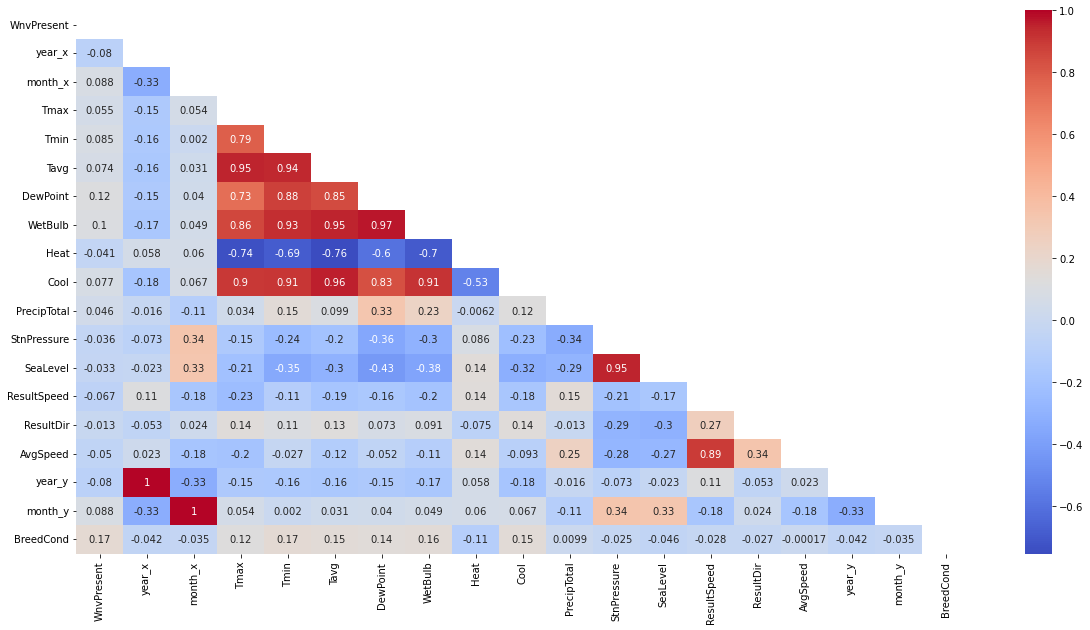

In [18]:
# Plotting heatmap to find the correlation between each feature with SalePrice
mask = np.zeros_like(df_corr.corr())
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(20, 10))
sns.heatmap(
    df_corr.corr(),
    cmap='coolwarm',
    annot=True,
    mask = mask
);

In [19]:
# To define the value the P-value
P = 0.0

# To return the o-value with response to BreedCondition
high_corr = df_corr.corr()['BreedCond']

# To return the feature with p-value higher than P
high_corr = high_corr[high_corr.values > P ]

# To define as list
high_corr = high_corr.index.tolist()

high_corr

['WnvPresent',
 'Tmax',
 'Tmin',
 'Tavg',
 'DewPoint',
 'WetBulb',
 'Cool',
 'PrecipTotal',
 'BreedCond']

In [20]:
# to define the high correlation feature list for plotting
high_corr_plot = high_corr.copy()

# As breed condtion is part of the correspodence, hence it is remove.
# WNVPresent is also removed as it would be the predicted value in next model
high_corr_plot.remove('BreedCond')
high_corr_plot.remove('WnvPresent')
high_corr_plot

['Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Cool', 'PrecipTotal']

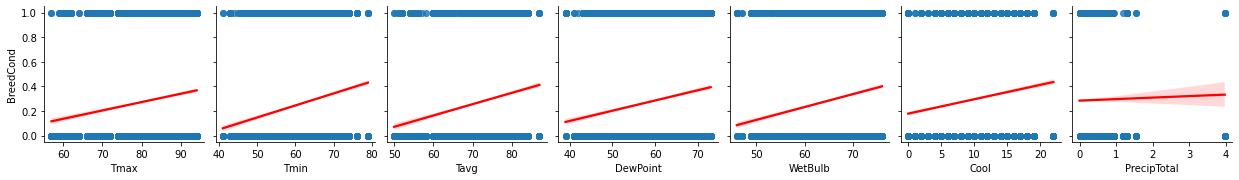

In [21]:
# Plot pairplot to check on the distribution against SalePrice
sns.pairplot(df_train, y_vars = ['BreedCond'] , x_vars = high_corr_plot,  kind="reg", plot_kws={'line_kws':{'color':'red'}})

In [22]:
# As Trap_cluster is one of the important in identifying the location, hence it is added into the high_corr
high_corr.extend(['Trap', 'Species','CodeSum'])

In [23]:
high_corr

['WnvPresent',
 'Tmax',
 'Tmin',
 'Tavg',
 'DewPoint',
 'WetBulb',
 'Cool',
 'PrecipTotal',
 'BreedCond',
 'Trap',
 'Species',
 'CodeSum']

### Creating Train Set with High Correlation Features

In [24]:
df_train_act = df_train[high_corr]

print(df_train_act.shape)
df_train_act.head()

(8797, 12)


,WnvPresent,Tmax,Tmin,Tavg,DewPoint,WetBulb,Cool,PrecipTotal,BreedCond,Trap,Species,CodeSum
Date,,,,,,,,,,,,
2007-05-29,0,88,60,74,58,65,9,0.0,0,T002,CULEX PIPIENS/RESTUANS,BRHZ
2007-05-29,0,88,60,74,58,65,9,0.0,0,T002,CULEX RESTUANS,BRHZ
2007-05-29,0,88,60,74,58,65,9,0.0,0,T007,CULEX RESTUANS,BRHZ
2007-05-29,0,88,60,74,58,65,9,0.0,0,T015,CULEX PIPIENS/RESTUANS,BRHZ
2007-05-29,0,88,60,74,58,65,9,0.0,0,T015,CULEX RESTUANS,BRHZ


### Creating Test Set with high correlation Features

In [25]:
# Remove 'BreedCond' & 'WnvPresent' from the high_corr list for test set
# Both features are part of the prediction in which it does not exist in test set
high_corr.remove('BreedCond')
high_corr.remove('WnvPresent')
high_corr.append('Id')

In [26]:
df_test_act = df_test[high_corr]

print(df_test_act.shape)
df_test_act.head()

(116293, 11)


,Tmax,Tmin,Tavg,DewPoint,WetBulb,Cool,PrecipTotal,Trap,Species,CodeSum,Id
Date,,,,,,,,,,,
2008-06-11,86,61,74,56,64,9,0.0,T002,CULEX PIPIENS/RESTUANS,moderate,1
2008-06-11,86,61,74,56,64,9,0.0,T002,CULEX RESTUANS,moderate,2
2008-06-11,86,61,74,56,64,9,0.0,T002,CULEX PIPIENS,moderate,3
2008-06-11,86,61,74,56,64,9,0.0,T002,CULEX SALINARIUS,moderate,4
2008-06-11,86,61,74,56,64,9,0.0,T002,CULEX TERRITANS,moderate,5


# Balancing the Datasets 

In [27]:
# Identify the value counts of the y-variable
df_train_act['WnvPresent'].value_counts(normalize = True)

0    0.962942
1    0.037058
Name: WnvPresent, dtype: float64

Inference:

As the datasets is highly unbalaned with ratio of 96%% vs 4% between WNV being not present vs present, to ensure the model can perform well, we would be looking at balancing the datasets.

Approaches to reduce the imbalanced dataset, the followings steps are to be taken;
- Drop rows with mosquitos species with no history of carrying WNV
- Drop rows with lower Tmin, Tmax, Weather Conditions where there was no history of mosquito breeding in that weather

By applying these measures, the datasets should be slightly better in terms of balancing.

## Remove rows with Mosquito with no history of carrying WNV

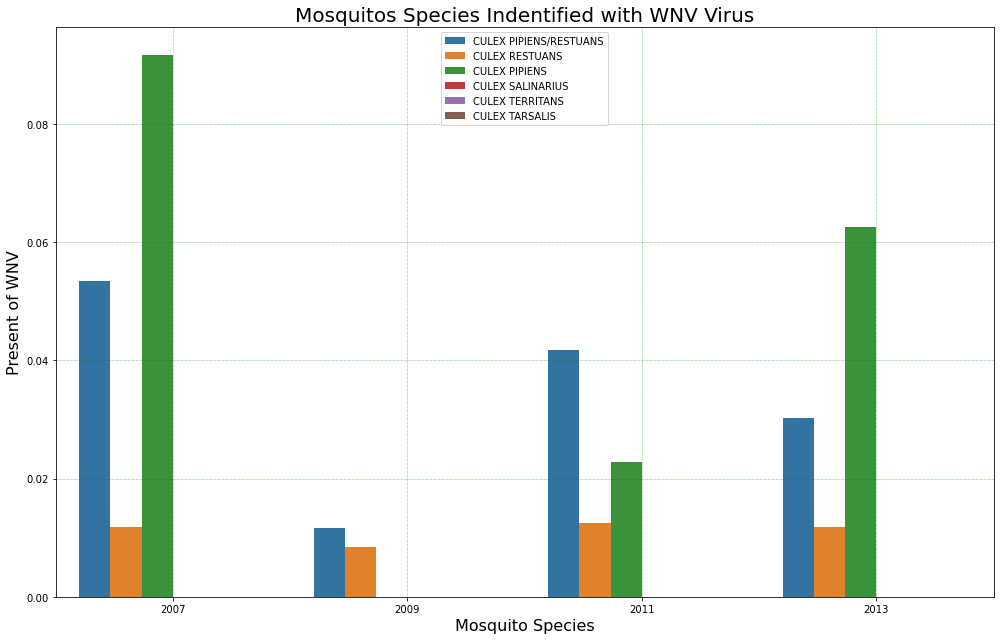

In [28]:
plt.figure(figsize = (14, 9))
sns.barplot(data=df_train_act, x=df_train_act.index.year, y="WnvPresent", hue="Species", ci = None)
plt.title("Mosquitos Species Indentified with WNV Virus", fontsize = 20)

plt.grid(color='g', linestyle=':', linewidth=0.5, visible = bool )
plt.legend()
plt.ylabel('Present of WNV', fontsize = 16)
plt.xlabel('Mosquito Species', fontsize = 16)
plt.savefig('./image/bar_species_virus.jpg')
plt.tight_layout()
plt.show()

Inference:

Based on the barchart above, we could infer that only 3 species of mosquitos carry the WNV. As 6 types of mosquitoes were noted during the survey, we would be dropping away rows that captured the 'Culex Salanarius', 'Culex Territans' & 'Culex Tarsalis' from our data.

In [29]:
# Define undangerous mosquito in list
undan_species = ['CULEX SALINARIUS', 'CULEX TERRITANS', 'CULEX TARSALIS']

In [30]:
# Remove the rows with undan_species from the datasets
print(f'Before removing undangerous mosquito species, the train dataset has {df_train_act.shape}')
df_train_act = df_train_act[~df_train_act['Species'].isin(undan_species)]
print(f'After removing undangerous mosquito species, the train dataset has {df_train_act.shape}')

Before removing undangerous mosquito species, the train dataset has (8797, 12)
After removing undangerous mosquito species, the train dataset has (8501, 12)


In [31]:
# Remove the rows with undan_species from the datasets
print(f'Before removing undangerous mosquito species, the test dataset has {df_test_act.shape}')
df_test_act = df_test_act[~df_test_act['Species'].isin(undan_species)]
print(f'After removing undangerous mosquito species, the test dataset has {df_test_act.shape}')

Before removing undangerous mosquito species, the test dataset has (116293, 11)
After removing undangerous mosquito species, the test dataset has (73240, 11)


In [32]:
# To counter check on the mosquito species in the test set
df_test_act['Species'].unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS',
       'UNSPECIFIED CULEX', 'CULEX ERRATICUS'], dtype=object)

Inference:

Since there are additional 2 species of mosquitos that were not found in the train dataset, these rows will be dropped

In [33]:
# Since there are differences in number of species, a list is created with species of mosquitos that were only found in test set
diff_species = set(df_test_act['Species']).difference(set(df_train_act['Species']))
diff_species

{'CULEX ERRATICUS', 'UNSPECIFIED CULEX'}

In [34]:
# Remove the rows with additional species from the test datasets
print(f'Before removing additional mosquito species, the test dataset has {df_test_act.shape}')
df_test_act = df_test_act[~df_test_act['Species'].isin(diff_species)]
print(f'After removing additional mosquito species, the test dataset has {df_test_act.shape}')

Before removing additional mosquito species, the test dataset has (73240, 11)
After removing additional mosquito species, the test dataset has (44550, 11)


## Identify Minimum Temperature for WNV Carrying Mosquito Breeding

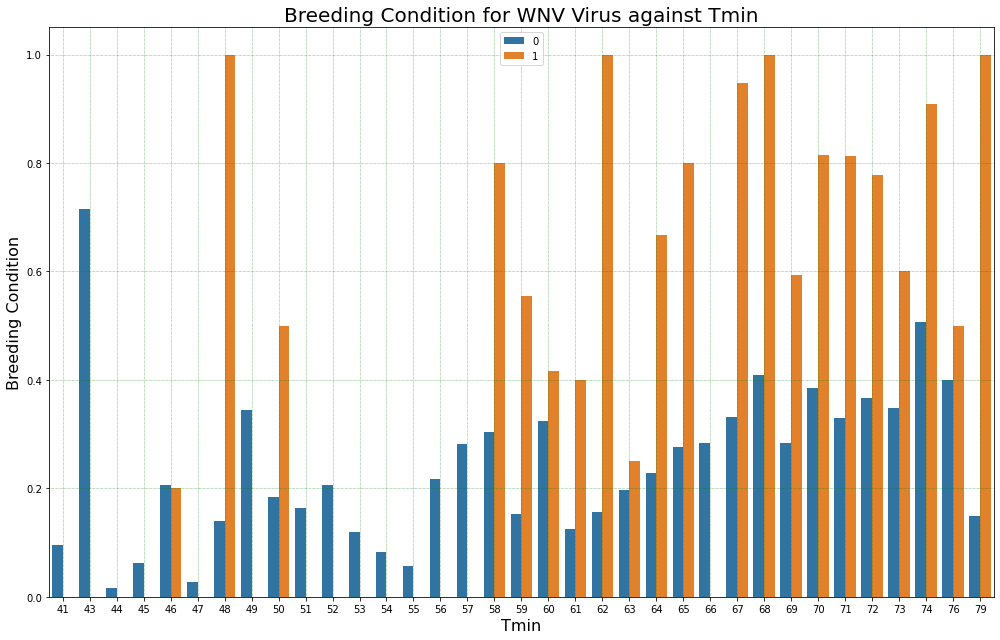

In [35]:
plt.figure(figsize = (14, 9))
sns.barplot(data=df_train_act, x="Tmin", y="BreedCond", hue="WnvPresent", ci = None)
plt.title("Breeding Condition for WNV Virus against Tmin", fontsize = 20)

plt.grid(color='g', linestyle=':', linewidth=0.5, visible = bool )
plt.legend()
plt.ylabel('Breeding Condition', fontsize = 16)
plt.xlabel('Tmin', fontsize = 16)
plt.savefig('./image/bar_tmin_virus.jpg')
plt.tight_layout()
plt.show()

Inference:

As we could see, where Tmin falls below 45 Farenheit, the breeding of WNV carrying mosquitos is null. Hence, these rows will be removed.

In [36]:
# Define minimum temperature for breeding of WNV
tmin_limit = 45

In [37]:
# Remove the rows with Tmin below the tmin_limit
print(f'Before removing rows with Tmin lower than the limit, the train dataset has {df_train_act.shape}')
df_train_act = df_train_act[df_train_act['Tmin'] > tmin_limit]
print(f'After removing rows with Tmin lower than the limit, the train dataset has {df_train_act.shape}')

Before removing rows with Tmin lower than the limit, the train dataset has (8501, 12)
After removing rows with Tmin lower than the limit, the train dataset has (8371, 12)


In [38]:
# Remove the rows with Tmin below the tmin_limit
print(f'Before removing rows with Tmin lower than the limit, the test dataset has  {df_test_act.shape}')
df_test_act = df_test_act[df_test_act['Tmin'] > tmin_limit]
print(f'After removing rows with Tmin lower than the limit, the test dataset has {df_test_act.shape}')

Before removing rows with Tmin lower than the limit, the test dataset has  (44550, 11)
After removing rows with Tmin lower than the limit, the test dataset has (44550, 11)


## Identify lowest Maximum Temperature for WNV Carrying Mosquito Breeding

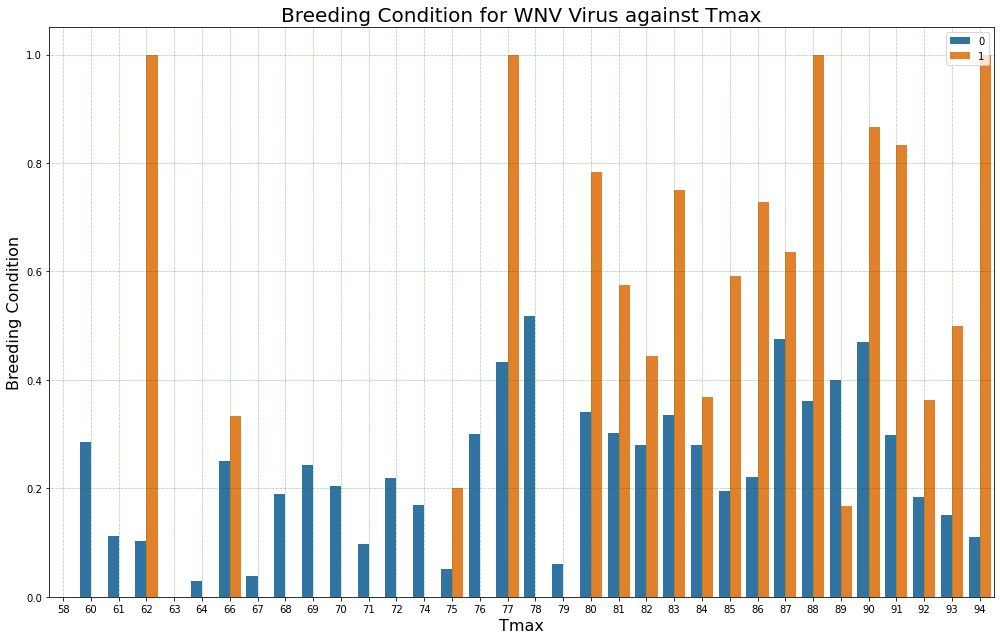

In [39]:
plt.figure(figsize = (14, 9))
sns.barplot(data=df_train_act, x="Tmax", y="BreedCond", hue="WnvPresent", ci = None)
plt.title("Breeding Condition for WNV Virus against Tmax", fontsize = 20)

plt.grid(color='g', linestyle=':', linewidth=0.5, visible = bool )
plt.legend()
plt.ylabel('Breeding Condition', fontsize = 16)
plt.xlabel('Tmax', fontsize = 16)
plt.savefig('./image/bar_tmax_virus.jpg')
plt.tight_layout()
plt.show()

Inference:

As we could see, where Tmax falls below 61 Farenheit, the breeding of WNV carrying mosquitos is null. Hence, these rows will be removed.

In [40]:
# Define minimum temperature for breeding of WNV
tmax_limit = 61

In [41]:
# Remove the rows with Tmax over the tmax_limit
print(f'Before removing rows with Tmax lower than the limit, the train dataset has {df_train_act.shape}')
df_train_act = df_train_act[df_train_act['Tmax'] > tmax_limit]
print(f'After removing rows with Tmax lower than the limit, the train dataset has {df_train_act.shape}')

Before removing rows with Tmax lower than the limit, the train dataset has (8371, 12)
After removing rows with Tmax lower than the limit, the train dataset has (8251, 12)


In [42]:
# Remove the rows with Tmax below the tmin_limit
print(f'Before removing rows with Tmax lower than the limit, the test dataset has  {df_test_act.shape}')
df_test_act = df_test_act[df_test_act['Tmax'] > tmax_limit]
print(f'After removing rows with Tmax lower than the limit, the test dataset has {df_test_act.shape}')

Before removing rows with Tmax lower than the limit, the test dataset has  (44550, 11)
After removing rows with Tmax lower than the limit, the test dataset has (44083, 11)


## Identify lowest Weather Condition for WNV Carrying Mosquito Breeding

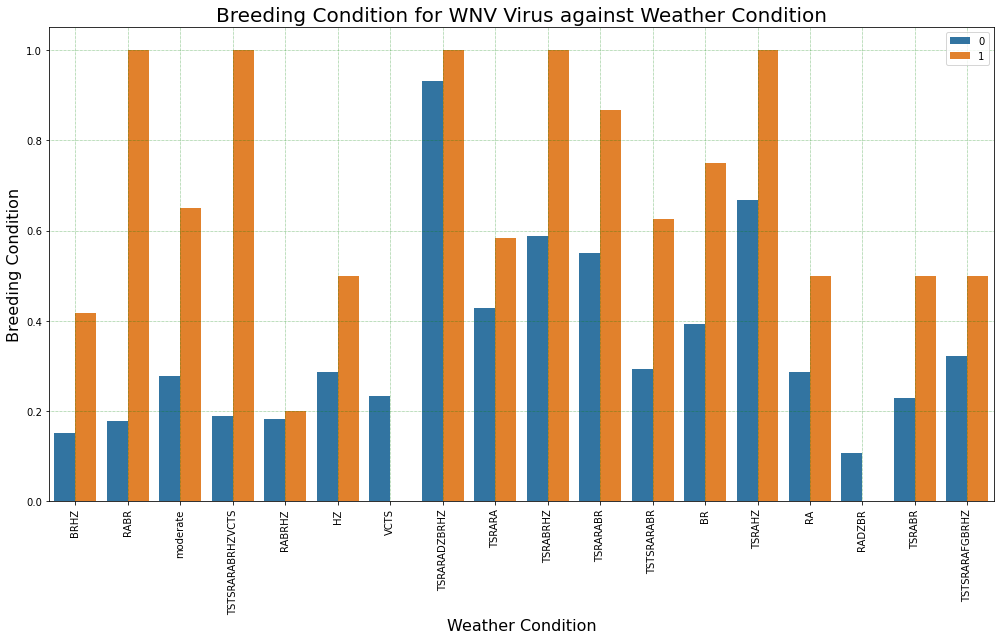

In [43]:
plt.figure(figsize = (14, 9))
sns.barplot(data=df_train_act, x="CodeSum", y="BreedCond", hue="WnvPresent", ci = None)
plt.title("Breeding Condition for WNV Virus against Weather Condition", fontsize = 20)

plt.grid(color='g', linestyle=':', linewidth=0.5, visible = bool )
plt.legend()
plt.ylabel('Breeding Condition', fontsize = 16)
plt.xlabel('Weather Condition', fontsize = 16)
plt.xticks(rotation = 90)
plt.savefig('./image/bar_weatcon_virus.jpg')
plt.tight_layout()
plt.show()

Inference:

We noticed that some weather conditon does not promote breeding of WNV carrying mosquitos or even suitable for mosquitos to breed on. 
Hence, we would identify the condtions where the it is not suitable for breeding of WNV mosquitos

In [44]:
# Identify weather condtion where Wnv is absent
code_sum_0 = df_train_act[df_train_act['WnvPresent'] == 0]['CodeSum'].unique()

# Identify weather condition where WNV is present
code_sum_1 = df_train_act[df_train_act['WnvPresent'] == 1]['CodeSum'].unique()

# To identify weather condition where WNV is always absent
code_sum_diff = list(set(code_sum_0).difference(set(code_sum_1)))
code_sum_diff

['TSRA',
 'TSTSRABR',
 'DZBR',
 'TSTSRARAVCTS',
 'TSTSRABRHZ',
 'TSRARABRVCTS',
 'TSRABRHZVCTS']

In [45]:
# Remove the rows with weaather condition where WNV mosquito will not breed from the datasets
print(f'Before removing rows with weaather condition where WNV mosquito will not breed, the train dataset has {df_train_act.shape}')
df_train_act = df_train_act[~df_train_act['CodeSum'].isin(code_sum_diff)]
print(f'After removing rows with weaather condition where WNV mosquito will not breed, the train dataset has {df_train_act.shape}')

Before removing rows with weaather condition where WNV mosquito will not breed, the train dataset has (8251, 12)
After removing rows with weaather condition where WNV mosquito will not breed, the train dataset has (7957, 12)


In [46]:
# Remove the rows with weaather condition where WNV mosquito will not breed from the datasets
print(f'Before removing rows with weaather condition where WNV mosquito will not breed, the test dataset has {df_test_act.shape}')
df_test_act = df_test_act[~df_test_act['CodeSum'].isin(code_sum_diff)]
print(f'After removing rows with weaather condition where WNV mosquito will not breed, the test dataset has {df_test_act.shape}')

Before removing rows with weaather condition where WNV mosquito will not breed, the test dataset has (44083, 11)
After removing rows with weaather condition where WNV mosquito will not breed, the test dataset has (42234, 11)


In [47]:
# Since there are differences in number of weather conditions, a list is created with weather conditions that were only found in test set
diff_code_sum = set(df_test_act['CodeSum']).difference(set(df_train_act['CodeSum']))
diff_code_sum

{'BCFGBR',
 'DZ',
 'RADZ',
 'TS',
 'TSBR',
 'TSRAFG+BRHZ',
 'TSRARABRHZ',
 'TSRARABRHZVCTS',
 'TSRARAVCTS',
 'TSTSRARA'}

In [48]:
# Remove the rows with additional weather condition from the test datasets
print(f'Before removing additional weather condition, the test dataset has {df_test_act.shape}')
df_test_act = df_test_act[~df_test_act['CodeSum'].isin(diff_code_sum)]
print(f'After removing additional weather condition, the test dataset has {df_test_act.shape}')

Before removing additional weather condition, the test dataset has (42234, 11)
After removing additional weather condition, the test dataset has (38869, 11)


In [49]:
df_train['WnvPresent'].value_counts()

0    8471
1     326
Name: WnvPresent, dtype: int64

In [50]:
df_train_act['WnvPresent'].value_counts()

0    7631
1     326
Name: WnvPresent, dtype: int64

## Identify Cooling Temperature for WNV Carrying Mosquito Breeding

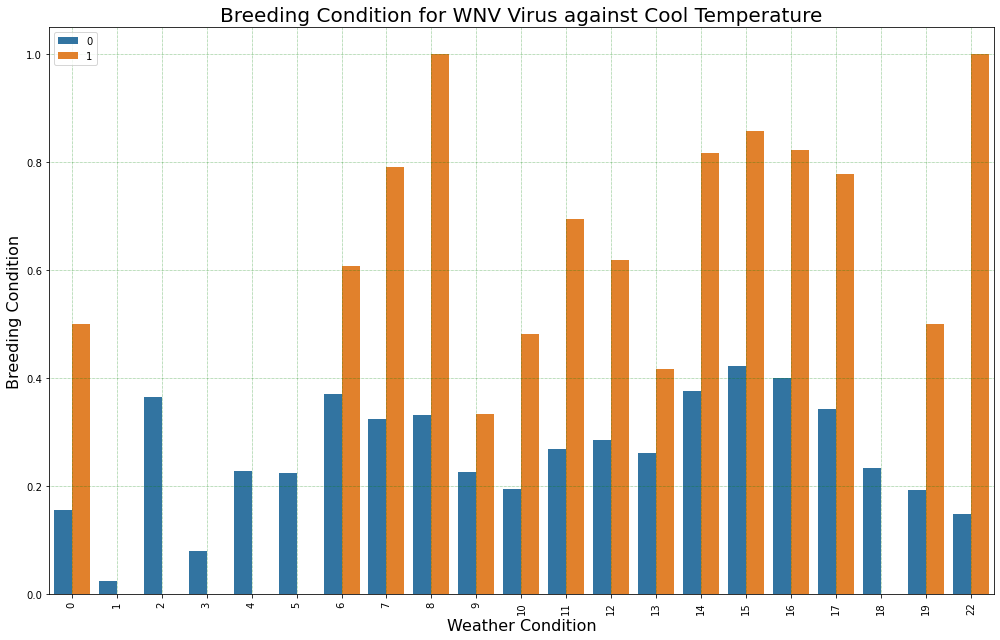

In [87]:
plt.figure(figsize = (14, 9))
sns.barplot(data=df_train_act, x="Cool", y="BreedCond", hue="WnvPresent", ci = None)
plt.title("Breeding Condition for WNV Virus against Cool Temperature", fontsize = 20)

plt.grid(color='g', linestyle=':', linewidth=0.5, visible = bool )
plt.legend()
plt.ylabel('Breeding Condition', fontsize = 16)
plt.xlabel('Weather Condition', fontsize = 16)
plt.xticks(rotation = 90)
plt.savefig('./image/bar_cool_virus.jpg')
plt.tight_layout()
plt.show()

Inference:

Noticed that when the temperature is 1 to 5 degrees below the 65 Fahrenheit, we noticed that the grow of WNV mosquito is null. 
When the cool value is 18, we noticed that there are 0 Present of WNV mosquito as well. However, this may be an outliers situation. Hence this row is not removed.

In [52]:
# To define the list of values to be removed from 'cool'
cool_lim = list(range(1,6))

In [53]:
# Identify if there is any present of WNV within the define list
df_train_act[(df_train_act['Cool'].isin(cool_lim)) & (df_train_act['WnvPresent'] == 1)]

,WnvPresent,Tmax,Tmin,Tavg,DewPoint,WetBulb,Cool,PrecipTotal,BreedCond,Trap,Species,CodeSum
Date,,,,,,,,,,,,
2007-10-04,1,83,56,70,56,62,5,0.0,0,T062,CULEX PIPIENS,moderate
2007-10-04,1,83,56,70,56,62,5,0.0,0,T156,CULEX PIPIENS,moderate
2009-09-03,1,75,56,66,54,59,1,0.0,0,T900,CULEX RESTUANS,moderate


Inference:

Seems like 'Cool' are not able to 100% eliminate the present of WNV as we could see present of WNV when the value is 1 and 5. Based on this observation, the rows that are define in `cool_lim` will not be removed.

In [54]:
df_train_act['WnvPresent'].value_counts(normalize = True)

0    0.95903
1    0.04097
Name: WnvPresent, dtype: float64

# Creating new dataframe for Train & Test Datasets

## Creating Train and Test Set for Model 1
Model 1 is to predict Breeding Condition in which the features are mainly relying on weather. Hence, 'Trap' and 'Species' will be removed.
The ordinal feature will be one-hot encoded

In [55]:
# Train dataset for Model 1
df_train_m1 = df_train_act.copy()
df_train_m1.drop(['Species', 'Trap'], axis = 1, inplace = True)
print(df_train_m1.shape)

# Test dataset for Model 1
df_test_m1 = df_test_act.copy()
df_test_m1.drop(['Species', 'Trap'], axis = 1, inplace = True)
print(df_test_m1.shape)

(7957, 10)
(38869, 9)


### One Hot Encoded - `CodeSum`

In [56]:
# Number of Trap in Train Dataset
print(df_train_m1['CodeSum'].nunique())
print(df_test_m1['CodeSum'].nunique())

18
12


In [57]:
# Since there are differences in number of weather condition, adjustment is required to identify the code prior dummify
train_test_diff = set(df_train_m1['CodeSum']).difference(set(df_test_m1['CodeSum']))
print(train_test_diff)

test_train_diff = set(df_test_m1['CodeSum']).difference(set(df_train_m1['CodeSum']))
print(train_test_diff)

{'TSRABRHZ', 'TSRARADZBRHZ', 'VCTS', 'TSTSRARAFGBRHZ', 'TSRAHZ', 'TSTSRARABRHZVCTS'}
{'TSRABRHZ', 'TSRARADZBRHZ', 'VCTS', 'TSTSRARAFGBRHZ', 'TSRAHZ', 'TSTSRARABRHZVCTS'}


In [58]:
# To dummify the categorical datasets for Train 
df_train_m1 = pd.get_dummies(df_train_m1, columns = ['CodeSum'], drop_first = True)
df_train_m1.shape

(7957, 26)

In [59]:
# To dummify the categorical datasets for test 
df_test_m1 = pd.get_dummies(df_test_m1, columns = ['CodeSum'], drop_first = True)
df_test_m1.shape

(38869, 19)

In [60]:
# Define empty list to store missing Weather Condition in train dataset
add_code_t = []
for a_code in list(train_test_diff):
    add_code_t.append('CodeSum_' + a_code)

# To add in missing weather condition from train set and assign the value as 0
df_test_m1[add_code_t] = 0

print(df_test_m1.shape)

(38869, 25)


In [61]:
# To rearrange the column in alphabetical order
df_train_m1.sort_index(axis=1, inplace=True)
df_test_m1.sort_index(axis=1, inplace=True)


### Exporting of Datasets

In [62]:
# df_train_m1.to_csv('./assets/df_train_m1.csv', index=False)
# df_test_m1.to_csv('./assets/df_test_m1.csv', index=False)

## Creating Train and Test Set for Model 2
Model 2 is to predict Present of WNV in which the features are mainly relying on breeding conditon, trap location and species. Hence, weather related features will be removed.
The ordinal feature will be one-hot encoded

In [63]:
df_train_act.columns

Index(['WnvPresent', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Cool',
       'PrecipTotal', 'BreedCond', 'Trap', 'Species', 'CodeSum'],
      dtype='object')

In [64]:
# Train dataset for Model 2
df_train_m2 = df_train_act[['WnvPresent','BreedCond', 'Trap', 'Species']]
print(df_train_m2.shape)

# Test dataset for Model 2
df_test_m2 = df_test_act[['Trap', 'Species', 'Id']]
print(df_test_m2.shape)

(7957, 4)
(38869, 3)


### One Hot Encoded - `Trap`

In [65]:
# Number of Trap in Train Dataset
print(df_train_m2['Trap'].nunique())
print(df_test_m2['Trap'].nunique())

136
149


In [66]:
# Since there are differences in number of trap, adjustment is required to identify the trap prior dummify
train_test_diff = set(df_train_m2['Trap']).difference(set(df_test_m2['Trap']))
print(train_test_diff)

test_train_diff = set(df_test_m2['Trap']).difference(set(df_train_m2['Trap']))
print(test_train_diff)

set()
{'T200B', 'T128A', 'T234', 'T090B', 'T218B', 'T218C', 'T200A', 'T090C', 'T218A', 'T090A', 'T002A', 'T065A', 'T002B'}


In [67]:
# To dummify the categorical datasets
df_train_m2 = pd.get_dummies(df_train_m2, columns = ['Trap'], drop_first = True)
df_train_m2.shape

(7957, 138)

In [68]:
# Define empty list to store missing traps in train dataset
add_trap = []
for a_trap in list(test_train_diff):
    add_trap.append('Trap_' + a_trap)

# To add in missing traps from train set and assign the value as 0
df_train_m2[add_trap] = 0

print(df_train_m2.shape)

(7957, 151)


In [69]:
# To dummify the categorical datasets
df_test_m2 = pd.get_dummies(df_test_m2, columns = ['Trap'], drop_first = True)

In [70]:
df_test_m2.shape

(38869, 150)

### One Hot Encoded - `Species`

In [71]:
# Number of Species in Train Dataset
print(df_train_m2['Species'].nunique())
print(df_test_m2['Species'].nunique())

3
3


In [72]:
# Since there are differences in number of mosquito Species, adjustment is required to identify the species prior dummify
train_test_diff = set(df_train_m2['Species']).difference(set(df_test_m2['Species']))
print(train_test_diff)

test_train_diff = set(df_test_m2['Species']).difference(set(df_train_m2['Species']))
print(test_train_diff)

set()
set()


Inference:

No additional mosquito species is identified.

In [73]:
# To rearrange the column in alphabetical order
df_train_m2.sort_index(axis=1, inplace=True)
df_test_m2.sort_index(axis=1, inplace=True)


### Exporting of Datasets

In [74]:
# df_train_m2.to_csv('./assets/df_train_m2.csv', index=False)
# df_test_m2.to_csv('./assets/df_test_m2.csv', index=False)

# Model 1 - Prediction for Breeding Condition

In [81]:
summ_m1 = pd.DataFrame()
def sum_score(model_text, model, X_train, X_test, y_train, y_test, remark = None):
    method = model_text
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    prediction = model.predict(X_test)
    precision = precision_score(y_test, prediction)
    recall = recall_score(y_test, prediction)
    f1 = f1_score(y_test, prediction)
    
    summary = pd.DataFrame({"Model" : method,
                            "Remark" : remark,
                            "Train Score" : train_score,
                            "Test Score" : test_score,
                            "Precision" : precision,
                            "Recall" : recall,
                            "F1 Score" : f1}, 
                           index = [0])
    return summary
    

In [82]:
# Train Test Split the data for model
m1_X = df_train_m1.drop(['BreedCond', 'WnvPresent'], axis = 1)
m1_y = df_train_m1['BreedCond']
m1_X_train, m1_X_test, m1_y_train, m1_y_test = train_test_split(m1_X, m1_y, test_size=0.2, random_state=42, stratify = m1_y)

In [83]:
# Standard Scallar
ss = StandardScaler()
m1_Z_train = ss.fit_transform(m1_X_train) 
m1_Z_test = ss.transform(m1_X_test) 

## Prediction with Normal Sampling Datasets and Default Parameters

### Logistic Regression

In [84]:
# Instantiate model
logreg = LogisticRegression(solver = 'newton-cg', random_state = 123) # changing solver b/c of convergence warning

# Fit the model
logreg.fit(m1_Z_train, m1_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('Base Model | Logistic Regression', logreg, m1_Z_train, m1_Z_test, m1_y_train, m1_y_test))

# To join the result into the summary table
summ_m1 = pd.concat([summ_m1, result])

# To display result
result

,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,Base Model | Logistic Regression,None,0.714533,0.720477,0.714286,0.134298,0.226087


### K-Neighbor Classifier

In [85]:
# Instantiate model
knn = KNeighborsClassifier() # changing solver b/c of convergence warning

# Fit the model
knn.fit(m1_Z_train, m1_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('K Nearest Neighbor', knn, m1_Z_train, m1_Z_test, m1_y_train, m1_y_test))

# To join the result into the summary table
summ_m1 = pd.concat([summ_m1, result])

# To display result
result

,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,K Nearest Neighbor,None,0.747997,0.738065,0.604361,0.400826,0.481988


### Decision Tree Classifier

In [86]:
# Instantiate model
dt = DecisionTreeClassifier(random_state = 123)

# Fit the model
dt.fit(m1_Z_train, m1_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('Decision Tree Classifier', dt, m1_Z_train, m1_Z_test, m1_y_train, m1_y_test))

# To join the result into the summary table
summ_m1 = pd.concat([summ_m1, result])

# To display result
result

,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,Decision Tree Classifier,None,0.774548,0.766332,0.739316,0.357438,0.481894


### Bagging Classifier

In [87]:
# Instantiate model
bagc = BaggingClassifier(random_state = 123)

# Fit the model
bagc.fit(m1_Z_train, m1_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('Bagging Classifier', bagc, m1_Z_train, m1_Z_test, m1_y_train, m1_y_test))

# To join the result into the summary table
summ_m1 = pd.concat([summ_m1, result])

# To display result
result

,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,Bagging Classifier,None,0.774234,0.762563,0.681507,0.411157,0.512887


### Random Forest Classider

In [88]:
# Instantiate model
rfc = RandomForestClassifier(random_state = 123)

# Fit the model
rfc.fit(m1_Z_train, m1_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('Random Foreset Classifier', rfc, m1_Z_train, m1_Z_test, m1_y_train, m1_y_test))

# To join the result into the summary table
summ_m1 = pd.concat([summ_m1, result])

# To display result
result

,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,Random Foreset Classifier,None,0.774548,0.761935,0.696629,0.384298,0.49534


### AdaBoost Classificer

In [89]:
# Instantiate model
abc = AdaBoostClassifier(random_state = 123)

# Fit the model
abc.fit(m1_Z_train, m1_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('AdaBoost Classifier', abc, m1_Z_train, m1_Z_test, m1_y_train, m1_y_test))

# To join the result into the summary table
summ_m1 = pd.concat([summ_m1, result])

# To display result
result

,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,AdaBoost Classifier,None,0.738256,0.734925,0.738462,0.198347,0.312704


### Support Vector Classificer

In [90]:
# Instantiate model
svc = SVC(random_state = 123)

# Fit the model
svc.fit(m1_Z_train, m1_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('Support Vector Classifier', svc, m1_Z_train, m1_Z_test, m1_y_train, m1_y_test))

# To join the result into the summary table
summ_m1 = pd.concat([summ_m1, result])

# To display result
result

,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,Support Vector Classifier,None,0.732129,0.738693,0.769841,0.200413,0.318033


In [91]:
summ_m1.reset_index(inplace = True)
summ_m1.drop(columns = 'index', inplace = True)
summ_m1

,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,Base Model | Logistic Regression,None,0.714533,0.720477,0.714286,0.134298,0.226087
1,K Nearest Neighbor,None,0.747997,0.738065,0.604361,0.400826,0.481988
2,Decision Tree Classifier,None,0.774548,0.766332,0.739316,0.357438,0.481894
3,Bagging Classifier,None,0.774234,0.762563,0.681507,0.411157,0.512887
4,Random Foreset Classifier,None,0.774548,0.761935,0.696629,0.384298,0.495340
5,AdaBoost Classifier,None,0.738256,0.734925,0.738462,0.198347,0.312704
6,Support Vector Classifier,None,0.732129,0.738693,0.769841,0.200413,0.318033


In [92]:
df_train_m1['BreedCond'].value_counts(normalize = True)

0    0.695865
1    0.304135
Name: BreedCond, dtype: float64

In [93]:
df_train_m1['BreedCond'].value_counts()

0    5537
1    2420
Name: BreedCond, dtype: int64

In [94]:
df_train_m1['WnvPresent'].value_counts()

0    7631
1     326
Name: WnvPresent, dtype: int64

Inference:

We could see a very low score for both Recall and F1 score. This could be due to the very unbalanced datasets we have despite the effort of removing irrelevant rows of data that is deemed not important in predicting the breeding condition for WNV.

In [95]:
df_train_m1['BreedCond'].value_counts(normalize = True)

0    0.695865
1    0.304135
Name: BreedCond, dtype: float64

## Prediction with Normal Sampling Datasets and Gridsearc CV

In [96]:
remark = 'GSCV'

### Logistic Regression

In [97]:
# Instantiate model
logreg_cv = GridSearchCV(estimator = LogisticRegression(),
            param_grid = {'max_iter': [50, 100, 200],
                          'solver': ['newton-cg', 'liblinear', 'saga']},
                         cv = 5,
                         verbose = 1,
                        scoring='f1')

# Fit the model
logreg_cv.fit(m1_Z_train, m1_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('Logistic Regression', logreg_cv, m1_Z_train, m1_Z_test, m1_y_train, m1_y_test, remark))

# To join the result into the summary table
summ_m1 = pd.concat([summ_m1, result])

# To display result
result

Fitting 5 folds for each of 9 candidates, totalling 45 fits


,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,Logistic Regression,GSCV,0.211714,0.226087,0.714286,0.134298,0.226087


### K-Neighbor Classifier

In [98]:
# Instantiate model
knn_cv =  GridSearchCV(estimator = KNeighborsClassifier(),
            param_grid = {'weights': ['uniform', 'distance'],
                          'leaf_size': [20, 30, 40],
                          'algorithm': ['auto', 'ball_tree', 'kd_tree']},
                         cv = 5,
                         verbose = 1,
                      scoring='f1')

# Fit the model
knn_cv.fit(m1_Z_train, m1_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('K Nearest Neighbor', knn_cv, m1_Z_train, m1_Z_test, m1_y_train, m1_y_test, remark))

# To join the result into the summary table
summ_m1 = pd.concat([summ_m1, result])

# To display result
result

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,K Nearest Neighbor,GSCV,0.512165,0.481988,0.604361,0.400826,0.481988


### Decision Tree Classifier

In [99]:
# Instantiate model
dt_gridcv = GridSearchCV(estimator = DecisionTreeClassifier(),
                    param_grid = {'max_depth': [2, 3, 5, 7],
                                  'min_samples_split': [5, 10, 15, 20],
                                  'min_samples_leaf': [2, 3, 4, 5, 6],
                                  'ccp_alpha': [0, 0.001, 0.01, 0.1, 1, 10]},
                         cv = 5,
                         verbose = 1,
                         scoring='f1')

# Fit the model
dt_gridcv.fit(m1_Z_train, m1_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('Decision Tree Classifier', dt_gridcv, m1_Z_train, m1_Z_test, m1_y_train, m1_y_test, remark))

# To join the result into the summary table
summ_m1 = pd.concat([summ_m1, result])

# To display result
result

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,Decision Tree Classifier,GSCV,0.468694,0.416667,0.744681,0.289256,0.416667


### Bagging Classifier

In [100]:
# Instantiate model
bagc_cv =  GridSearchCV(estimator = BaggingClassifier(),
            param_grid = {'bootstrap': [True, False],
                          'n_estimators': [10, 20, 30]},
                         cv = 5,
                         verbose = 1,
                       scoring='f1')

# Fit the model
bagc_cv.fit(m1_Z_train, m1_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('Bagging Classifier', bagc_cv, m1_Z_train, m1_Z_test, m1_y_train, m1_y_test, remark))

# To join the result into the summary table
summ_m1 = pd.concat([summ_m1, result])

# To display result
result

Fitting 5 folds for each of 6 candidates, totalling 30 fits


,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,Bagging Classifier,GSCV,0.524046,0.487805,0.708661,0.371901,0.487805


### Random Forest Classider

In [101]:
# Instantiate model
rfc_cv = GridSearchCV(estimator = RandomForestClassifier(),
            param_grid = {'criterion': ['gini', 'entropy'],
                          'n_estimators': [100, 200, 300],
                          'max_leaf_nodes': [None, 100, 200],
                         'random_state': [123]},
                         cv = 5,
                         verbose = 1,
                     scoring='f1')

# Fit the model
rfc_cv.fit(m1_Z_train, m1_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('Random Foreset Classifier', rfc_cv, m1_Z_train, m1_Z_test, m1_y_train, m1_y_test, remark))

# To join the result into the summary table
summ_m1 = pd.concat([summ_m1, result])

# To display result
result

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,Random Foreset Classifier,GSCV,0.524046,0.487805,0.708661,0.371901,0.487805


### AdaBoost Classificer

In [102]:
# Instantiate model
abc_cv = GridSearchCV(estimator = AdaBoostClassifier(),
            param_grid = {'learning_rate': [1, 0.9],
                          'n_estimators': [50, 100, 200],
                         'random_state': [123]},
                         cv = 5,
                         verbose = 1,
                     scoring='f1')

# Fit the model
abc_cv.fit(m1_Z_train, m1_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('AdaBoost Classifier', abc_cv, m1_Z_train, m1_Z_test, m1_y_train, m1_y_test, remark))

# To join the result into the summary table
summ_m1 = pd.concat([summ_m1, result])

# To display result
result

Fitting 5 folds for each of 6 candidates, totalling 30 fits


,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,AdaBoost Classifier,GSCV,0.48686,0.449857,0.733645,0.32438,0.449857


### Support Vector Classifier

In [103]:
# Instantiate model
svc_cv = GridSearchCV(estimator = SVC(),
            param_grid = {'C': [1, 0.9],
                          'degree': [3,4],
                          'cache_size': [200, 300],
                         'random_state': [123]},
                         cv = 5,
                         verbose = 1,
                     scoring='f1')

# Fit the model
svc_cv.fit(m1_Z_train, m1_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('Support Vector Classifier', svc_cv, m1_Z_train, m1_Z_test, m1_y_train, m1_y_test, remark))

# To join the result into the summary table
summ_m1 = pd.concat([summ_m1, result])

# To display result
result

Fitting 5 folds for each of 8 candidates, totalling 40 fits


,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,Support Vector Classifier,GSCV,0.29458,0.318033,0.769841,0.200413,0.318033


In [104]:
m1_y.value_counts()

0    5537
1    2420
Name: BreedCond, dtype: int64

Inference:

As we noticed, knowing that the datasets for breeding condition is imbalanced, we would be trying to apply SMOTE oversampling method to train the model

## Prediction for Breeding Condition with SMOTE Oversampling

In [105]:
# Initialize SMOTE
smote = SMOTE(random_state = 123)

In [106]:
m1_X = df_train_m1.drop(['BreedCond','WnvPresent'], axis = 1)
m1_y = df_train_m1['BreedCond']

In [107]:
m1_X_s, m1_y_s = smote.fit_resample(m1_X, m1_y)

In [108]:
m1_y_s.value_counts()

0    5537
1    5537
Name: BreedCond, dtype: int64

In [109]:
# Train Test Split the data for model
# m1_X = df_train_m1.drop('BreedCond', axis = 1)
# m1_y = df_train_m1['BreedCond']
m1_X_train, m1_X_test, m1_y_train, m1_y_test = train_test_split(m1_X_s, m1_y_s, test_size=0.2, random_state=42, stratify = m1_y_s)

In [110]:
# Standard Scallar
ss = StandardScaler()
m1_Z_train = ss.fit_transform(m1_X_train) 
m1_Z_test = ss.transform(m1_X_test) 

In [111]:
# Set the remark for model
remark = 'SMOTE'

### Logistic Regression

In [112]:
# Instantiate model
logreg_m = LogisticRegression(solver = 'newton-cg', random_state = 123) # changing solver b/c of convergence warning

# Fit the model
logreg_m.fit(m1_Z_train, m1_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('Logistic Regression', logreg_m, m1_Z_train, m1_Z_test, m1_y_train, m1_y_test, remark))

# To join the result into the summary table
summ_m1 = pd.concat([summ_m1, result])

# To display result
result

,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,Logistic Regression,SMOTE,0.636754,0.620767,0.620596,0.620596,0.620596


### K-Neighbor Classifier

In [113]:
# Instantiate model
knn_m = KNeighborsClassifier() # changing solver b/c of convergence warning

# Fit the model
knn_m.fit(m1_Z_train, m1_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('K Nearest Neighbor', knn_m, m1_Z_train, m1_Z_test, m1_y_train, m1_y_test, remark))

# To join the result into the summary table
summ_m1 = pd.concat([summ_m1, result])

# To display result
result

,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,K Nearest Neighbor,SMOTE,0.668586,0.660045,0.656085,0.672087,0.663989


### Decision Tree Classifier

In [114]:
# Instantiate model
dt_m = DecisionTreeClassifier(random_state = 123)

# Fit the model
dt_m.fit(m1_Z_train, m1_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('Decision Tree Classifier', dt_m, m1_Z_train, m1_Z_test, m1_y_train, m1_y_test, remark))

# To join the result into the summary table
summ_m1 = pd.concat([summ_m1, result])

# To display result
result

,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,Decision Tree Classifier,SMOTE,0.713625,0.695711,0.715852,0.6486,0.680569


### Bagging Classifier

In [115]:
# Instantiate model
bagc_m = BaggingClassifier(random_state = 123)

# Fit the model
bagc_m.fit(m1_Z_train, m1_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('Bagging Classifier', bagc_m, m1_Z_train, m1_Z_test, m1_y_train, m1_y_test, remark))

# To join the result into the summary table
summ_m1 = pd.concat([summ_m1, result])

# To display result
result

,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,Bagging Classifier,SMOTE,0.712383,0.694808,0.692927,0.699187,0.696043


### Random Forest Classider

In [116]:
# Instantiate model
rfc_m = RandomForestClassifier(random_state = 123)

# Fit the model
rfc_m.fit(m1_Z_train, m1_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('Random Foreset Classifier', rfc_m, m1_Z_train, m1_Z_test, m1_y_train, m1_y_test, remark))

# To join the result into the summary table
summ_m1 = pd.concat([summ_m1, result])

# To display result
result

,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,Random Foreset Classifier,SMOTE,0.713625,0.695711,0.715852,0.6486,0.680569


### AdaBoost Classificer

In [117]:
# Instantiate model
abc_m = AdaBoostClassifier(random_state = 123)

# Fit the model
abc_m.fit(m1_Z_train, m1_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('AdaBoost Classifier', abc_m, m1_Z_train, m1_Z_test, m1_y_train, m1_y_test, remark))

# To join the result into the summary table
summ_m1 = pd.concat([summ_m1, result])

# To display result
result

,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,AdaBoost Classifier,SMOTE,0.67818,0.65237,0.665358,0.612466,0.637817


### Support Vector Classificer

In [118]:
# Instantiate model
svc_m = SVC(random_state = 123)

# Fit the model
svc_m.fit(m1_Z_train, m1_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('Support Vector Classifier', svc_m, m1_Z_train, m1_Z_test, m1_y_train, m1_y_test, remark))

# To join the result into the summary table
summ_m1 = pd.concat([summ_m1, result])

# To display result
result

,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,Support Vector Classifier,SMOTE,0.641156,0.632054,0.627622,0.6486,0.637939


## Prediction for Breeding Condition with SMOTE Oversampling and Gridsearch CV

In [119]:
# Initialize SMOTE
smote = SMOTE(random_state = 123)

In [120]:
m1_X = df_train_m1.drop(['BreedCond','WnvPresent'], axis = 1)
m1_y = df_train_m1['BreedCond']

In [121]:
m1_X_s, m1_y_s = smote.fit_resample(m1_X, m1_y)

In [122]:
m1_y_s.value_counts()

0    5537
1    5537
Name: BreedCond, dtype: int64

In [123]:
# Train Test Split the data for model
# m1_X = df_train_m1.drop('BreedCond', axis = 1)
# m1_y = df_train_m1['BreedCond']
m1_X_train, m1_X_test, m1_y_train, m1_y_test = train_test_split(m1_X_s, m1_y_s, test_size=0.2, random_state=42, stratify = m1_y_s)

In [124]:
# Standard Scallar
ss = StandardScaler()
m1_Z_train = ss.fit_transform(m1_X_train) 
m1_Z_test = ss.transform(m1_X_test) 

In [125]:
# Set the remark for model
remark = 'SMOTE & GSCV'

### Logistic Regression

In [126]:
# Instantiate model
logreg_cv_s = GridSearchCV(estimator = LogisticRegression(),
            param_grid = {'max_iter': [50, 100, 200],
                          'solver': ['newton-cg', 'liblinear', 'saga']},
                         cv = 5,
                         verbose = 1,
                          scoring='f1')

# Fit the model
logreg_cv_s.fit(m1_Z_train, m1_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('Logistic Regression', logreg_cv_s, m1_Z_train, m1_Z_test, m1_y_train, m1_y_test, remark))

# To join the result into the summary table
summ_m1 = pd.concat([summ_m1, result])

# To display result
result

Fitting 5 folds for each of 9 candidates, totalling 45 fits


,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,Logistic Regression,SMOTE & GSCV,0.630977,0.614964,0.621198,0.608853,0.614964


### K-Neighbor Classifier

In [127]:
# Instantiate model
knn_cv_s =  GridSearchCV(estimator = KNeighborsClassifier(),
            param_grid = {'weights': ['uniform', 'distance'],
                          'leaf_size': [20, 30, 40],
                          'algorithm': ['auto', 'ball_tree', 'kd_tree']},
                         cv = 5,
                         verbose = 1,
                        scoring='f1')

# Fit the model
knn_cv_s.fit(m1_Z_train, m1_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('K Nearest Neighbor', knn_cv_s, m1_Z_train, m1_Z_test, m1_y_train, m1_y_test, remark))

# To join the result into the summary table
summ_m1 = pd.concat([summ_m1, result])

# To display result
result

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,K Nearest Neighbor,SMOTE & GSCV,0.673599,0.664882,0.656966,0.67299,0.664882


### Decision Tree Classifier

In [128]:
# Instantiate model
dt_cv_s = GridSearchCV(estimator = DecisionTreeClassifier(),
                    param_grid = {'max_depth': [2, 3, 5, 7],
                                  'min_samples_split': [5, 10, 15, 20],
                                  'min_samples_leaf': [2, 3, 4, 5, 6],
                                  'ccp_alpha': [0, 0.001, 0.01, 0.1, 1, 10]},
                    cv = 5,
                    verbose = 1,
                      scoring='f1')

# Fit the model
dt_cv_s.fit(m1_Z_train, m1_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('Decision Tree Classifier', dt_cv_s, m1_Z_train, m1_Z_test, m1_y_train, m1_y_test, remark))

# To join the result into the summary table
summ_m1 = pd.concat([summ_m1, result])

# To display result
result

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,Decision Tree Classifier,SMOTE & GSCV,0.674957,0.676143,0.588235,0.794941,0.676143


### Bagging Classifier

In [129]:
# Instantiate model
bagc_cv_s =  GridSearchCV(estimator = BaggingClassifier(),
            param_grid = {'bootstrap': [True, False],
                          'n_estimators': [10, 20, 30]},
                         cv = 5,
                         verbose = 1,
                         scoring='f1')

# Fit the model
bagc_cv_s.fit(m1_Z_train, m1_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('Bagging Classifier', bagc_cv_s, m1_Z_train, m1_Z_test, m1_y_train, m1_y_test, remark))

# To join the result into the summary table
summ_m1 = pd.concat([summ_m1, result])

# To display result
result

Fitting 5 folds for each of 6 candidates, totalling 30 fits


,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,Bagging Classifier,SMOTE & GSCV,0.696399,0.679426,0.722279,0.641373,0.679426


### Random Forest Classider

In [130]:
# Instantiate model
rfc_cv_s = GridSearchCV(estimator = RandomForestClassifier(),
            param_grid = {'criterion': ['gini', 'entropy'],
                          'n_estimators': [100, 200, 300],
                          'max_leaf_nodes': [None, 100, 200],
                         'random_state': [123]},
                         cv = 5,
                         verbose = 1,
                       scoring='f1')

# Fit the model
rfc_cv_s.fit(m1_Z_train, m1_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('Random Foreset Classifier', rfc_cv_s, m1_Z_train, m1_Z_test, m1_y_train, m1_y_test, remark))

# To join the result into the summary table
summ_m1 = pd.concat([summ_m1, result])

# To display result
result

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,Random Foreset Classifier,SMOTE & GSCV,0.71276,0.691858,0.689068,0.69467,0.691858


### AdaBoost Classificer

In [131]:
# Instantiate model
abc_cv_s = GridSearchCV(estimator = AdaBoostClassifier(),
            param_grid = {'learning_rate': [1, 0.9],
                          'n_estimators': [50, 100, 200],
                         'random_state': [123]},
                         cv = 5,
                         verbose = 1,
                       scoring='f1')
# Fit the model
abc_cv_s.fit(m1_Z_train, m1_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('AdaBoost Classifier', abc_cv_s, m1_Z_train, m1_Z_test, m1_y_train, m1_y_test, remark))

# To join the result into the summary table
summ_m1 = pd.concat([summ_m1, result])

# To display result
result

Fitting 5 folds for each of 6 candidates, totalling 30 fits


,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,AdaBoost Classifier,SMOTE & GSCV,0.682716,0.662438,0.664545,0.660343,0.662438


### Support Vector Classifier

In [132]:
# Instantiate model
svc_cv_s = GridSearchCV(estimator = SVC(),
            param_grid = {'C': [1, 0.9],
                          'degree': [3,4],
                          'cache_size': [200, 300],
                         'random_state': [123]},
                         cv = 5,
                         verbose = 1,
                       scoring='f1')

# Fit the model
svc_cv_s.fit(m1_Z_train, m1_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('Support Vector Classifier', svc_cv_s, m1_Z_train, m1_Z_test, m1_y_train, m1_y_test, remark))

# To join the result into the summary table
summ_m1 = pd.concat([summ_m1, result])

# To display result
result

Fitting 5 folds for each of 8 candidates, totalling 40 fits


,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,Support Vector Classifier,SMOTE & GSCV,0.645952,0.637939,0.627622,0.6486,0.637939


In [133]:
summ_m1.reset_index(inplace = True)
summ_m1.drop(columns = 'index', inplace = True)
summ_m1

,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,Base Model | Logistic Regression,None,0.714533,0.720477,0.714286,0.134298,0.226087
1,K Nearest Neighbor,None,0.747997,0.738065,0.604361,0.400826,0.481988
2,Decision Tree Classifier,None,0.774548,0.766332,0.739316,0.357438,0.481894
3,Bagging Classifier,None,0.774234,0.762563,0.681507,0.411157,0.512887
4,Random Foreset Classifier,None,0.774548,0.761935,0.696629,0.384298,0.495340
5,AdaBoost Classifier,None,0.738256,0.734925,0.738462,0.198347,0.312704
6,Support Vector Classifier,None,0.732129,0.738693,0.769841,0.200413,0.318033
7,Logistic Regression,GSCV,0.211714,0.226087,0.714286,0.134298,0.226087
8,K Nearest Neighbor,GSCV,0.512165,0.481988,0.604361,0.400826,0.481988
9,Decision Tree Classifier,GSCV,0.468694,0.416667,0.744681,0.289256,0.416667


In [134]:
# Define a new dataframe for plotting
summ_1_plot = summ_m1.copy()

# Replace the remark for consistency
summ_1_plot.at[0, 'Model']= 'Logistic Regression'
summ_1_plot['Remark'].replace(np.nan , 'Normal Sampling', inplace = True)

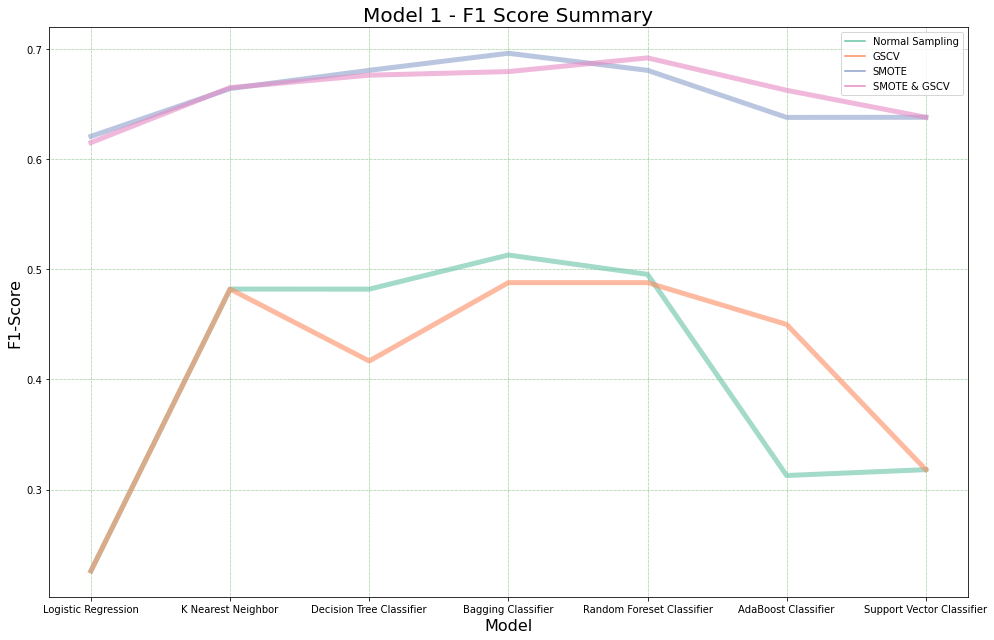

In [135]:
plt.figure(figsize = (14, 9))
sns.lineplot(data=summ_1_plot, x='Model', y="F1 Score", hue="Remark", ci = None, palette = "Set2",  linewidth = 5, alpha = 0.6)
plt.title("Model 1 - F1 Score Summary", fontsize = 20)

plt.grid(color='g', linestyle=':', linewidth=0.5, visible = bool )
plt.legend()
plt.ylabel('F1-Score', fontsize = 16)
plt.xlabel('Model', fontsize = 16)
plt.savefig('./image/m1_score_summary.jpg')
plt.tight_layout()
plt.show()

Inference:

Based on the summary score above, we would use the metric of F1-Score to measure the performance of our models. 
We could see that the F1-score for Adaboost Model performs the best on both original cleaned dataset and SMOTE oversampling methods. 

To acertain on the F1-score, GridSearchCV was also done on both sampling methods. From the result, we could see that the SMOTE oversampling methods indeed performed better than normal sampling. The scores are around the range of 0.65.
Out of the models, we have narrowed down to Bagging Classifier with SMOTE sampling and Bagging Classider with SMOTE & GridSearch CV. Both scores are really close but the train and test score for the Bagging Classifier with SMOTE is slightly higher. 

Hence, Bagging Calssification will be used to predict the Breeding Condition on both train and test datasets for Model 2 deployment.

## Model 1 Prediction

In [136]:
test_m1 = df_test_m1.copy()

In [137]:
# To verify on the columns in test datasets
test_m1.columns

Index(['CodeSum_BRHZ', 'CodeSum_HZ', 'CodeSum_RA', 'CodeSum_RABR',
       'CodeSum_RABRHZ', 'CodeSum_RADZBR', 'CodeSum_TSRABR',
       'CodeSum_TSRABRHZ', 'CodeSum_TSRAHZ', 'CodeSum_TSRARA',
       'CodeSum_TSRARABR', 'CodeSum_TSRARADZBRHZ', 'CodeSum_TSTSRARABR',
       'CodeSum_TSTSRARABRHZVCTS', 'CodeSum_TSTSRARAFGBRHZ', 'CodeSum_VCTS',
       'CodeSum_moderate', 'Cool', 'DewPoint', 'Id', 'PrecipTotal', 'Tavg',
       'Tmax', 'Tmin', 'WetBulb'],
      dtype='object')

In [138]:
# 'Id' column will be dropped here for model prediction
test_m1 = test_m1.drop('Id', axis = 1)

In [139]:
test_m1.columns

Index(['CodeSum_BRHZ', 'CodeSum_HZ', 'CodeSum_RA', 'CodeSum_RABR',
       'CodeSum_RABRHZ', 'CodeSum_RADZBR', 'CodeSum_TSRABR',
       'CodeSum_TSRABRHZ', 'CodeSum_TSRAHZ', 'CodeSum_TSRARA',
       'CodeSum_TSRARABR', 'CodeSum_TSRARADZBRHZ', 'CodeSum_TSTSRARABR',
       'CodeSum_TSTSRARABRHZVCTS', 'CodeSum_TSTSRARAFGBRHZ', 'CodeSum_VCTS',
       'CodeSum_moderate', 'Cool', 'DewPoint', 'PrecipTotal', 'Tavg', 'Tmax',
       'Tmin', 'WetBulb'],
      dtype='object')

In [140]:
# Standard Scaler the test dataset
test_m1_ss = ss.transform(test_m1)

# Model Prediction on Train dataset
test_m1_pred = bagc_cv_s.predict(test_m1_ss)

In [141]:
test_m1['BreedCond'] = test_m1_pred

In [142]:
test_m1['Id'] = df_test_m1['Id']

In [143]:
df_test_m2['BreedCond'] = test_m1_pred

In [144]:
# test_m1.to_csv('./assets/test_m1_pred.csv', index=False)

In [145]:
# df_test_m2.to_csv('./assets/test_m2_pred.csv', index=False)

# Model 2 - Prediction for WNV Present

In [146]:
summ_m2 = pd.DataFrame()    

In [147]:
# Train Test Split the data for model
m2_X = df_train_m2.drop(['Species', 'WnvPresent'], axis = 1)
m2_y = df_train_m2['WnvPresent']
m2_X_train, m2_X_test, m2_y_train, m2_y_test = train_test_split(m2_X, m2_y, test_size=0.2, random_state=42, stratify = m2_y)

In [148]:
# Standard Scallar
ss_2 = StandardScaler()
m2_Z_train = ss_2.fit_transform(m2_X_train) 
m2_Z_test = ss_2.transform(m2_X_test) 

## Normal Sampling Datasets

### Logistic Regression

In [149]:
# Instantiate model
logreg_2 = LogisticRegression(solver = 'newton-cg', random_state = 123) # changing solver b/c of convergence warning

# Fit the model
logreg_2.fit(m2_Z_train, m2_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('Base Model | Logistic Regression', logreg_2, m2_Z_train, m2_Z_test, m2_y_train, m2_y_test))

# To join the result into the summary table
summ_m2 = pd.concat([summ_m2, result])

# To display result
result

,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,Base Model | Logistic Regression,None,0.958995,0.959171,0.0,0.0,0.0


### K-Neighbor Classifier

In [150]:
# Instantiate model
knn_2 = KNeighborsClassifier() # changing solver b/c of convergence warning

# Fit the model
knn_2.fit(m2_Z_train, m2_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('K Nearest Neighbor', knn_2, m2_Z_train, m2_Z_test, m2_y_train, m2_y_test))

# To join the result into the summary table
summ_m2 = pd.concat([summ_m2, result])

# To display result
result

,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,K Nearest Neighbor,None,0.959309,0.960427,1.0,0.030769,0.059701


### Decision Tree Classifier

In [151]:
# Instantiate model
dt_2 = DecisionTreeClassifier(random_state = 123)

# Fit the model
dt_2.fit(m2_Z_train, m2_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('Decision Tree Classifier', dt_2, m2_Z_train, m2_Z_test, m2_y_train, m2_y_test))

# To join the result into the summary table
summ_m2 = pd.concat([summ_m2, result])

# To display result
result

,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,Decision Tree Classifier,None,0.959466,0.960427,1.0,0.030769,0.059701


### Bagging Classifier

In [152]:
# Instantiate model
bagc_2 = BaggingClassifier(random_state = 123)

# Fit the model
bagc_2.fit(m2_Z_train, m2_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('Bagging Classifier', bagc_2, m2_Z_train, m2_Z_test, m2_y_train, m2_y_test))

# To join the result into the summary table
summ_m2 = pd.concat([summ_m2, result])

# To display result
result

,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,Bagging Classifier,None,0.959466,0.960427,1.0,0.030769,0.059701


### Random Forest Classider

In [153]:
# Instantiate model
rfc_2 = RandomForestClassifier(random_state = 123)

# Fit the model
rfc_2.fit(m2_Z_train, m2_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('Random Foreset Classifier', rfc_2, m2_Z_train, m2_Z_test, m2_y_train, m2_y_test))

# To join the result into the summary table
summ_m2 = pd.concat([summ_m2, result])

# To display result
result

,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,Random Foreset Classifier,None,0.959466,0.960427,1.0,0.030769,0.059701


### AdaBoost Classificer

In [154]:
# Instantiate model
abc_2 = AdaBoostClassifier(random_state = 123)

# Fit the model
abc_2.fit(m2_Z_train, m2_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('AdaBoost Classifier', abc_2, m2_Z_train, m2_Z_test, m2_y_train, m2_y_test))

# To join the result into the summary table
summ_m2 = pd.concat([summ_m2, result])

# To display result
result

,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,AdaBoost Classifier,None,0.958995,0.959171,0.0,0.0,0.0


### Support Vector Classificer

In [155]:
# Instantiate model
svc_2 = SVC(random_state = 123)

# Fit the model
svc_2.fit(m2_Z_train, m2_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('Support Vector Classifier', svc_2, m2_Z_train, m2_Z_test, m2_y_train, m2_y_test))

# To join the result into the summary table
summ_m2 = pd.concat([summ_m2, result])

# To display result
result

,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,Support Vector Classifier,None,0.958995,0.959171,0.0,0.0,0.0


In [156]:
summ_m2.reset_index(inplace = True)
summ_m2.drop(columns = 'index', inplace = True)
summ_m2

,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,Base Model | Logistic Regression,None,0.958995,0.959171,0.0,0.000000,0.000000
1,K Nearest Neighbor,None,0.959309,0.960427,1.0,0.030769,0.059701
2,Decision Tree Classifier,None,0.959466,0.960427,1.0,0.030769,0.059701
3,Bagging Classifier,None,0.959466,0.960427,1.0,0.030769,0.059701
4,Random Foreset Classifier,None,0.959466,0.960427,1.0,0.030769,0.059701
5,AdaBoost Classifier,None,0.958995,0.959171,0.0,0.000000,0.000000
6,Support Vector Classifier,None,0.958995,0.959171,0.0,0.000000,0.000000


## Normal Sampling Datasets with GridSearch CV

In [157]:
remark = 'GSCV'

### Logistic Regression

In [158]:
# Instantiate model
logreg_2_cv = GridSearchCV(estimator = LogisticRegression(),
            param_grid = {'max_iter': [50, 100, 200],
                          'solver': ['newton-cg', 'liblinear', 'saga']},
                         cv = 5,
                         verbose = 1)

# Fit the model
logreg_2_cv.fit(m2_Z_train, m2_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('Logistic Regression', logreg_2_cv, m2_Z_train, m2_Z_test, m2_y_train, m2_y_test, remark))

# To join the result into the summary table
summ_m2 = pd.concat([summ_m2, result])

# To display result
result

Fitting 5 folds for each of 9 candidates, totalling 45 fits


,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,Logistic Regression,GSCV,0.958995,0.959171,0.0,0.0,0.0


### K-Neighbor Classifier

In [159]:
# Instantiate model
knn_2_cv =  GridSearchCV(estimator = KNeighborsClassifier(),
            param_grid = {'weights': ['uniform', 'distance'],
                          'leaf_size': [20, 30, 40],
                          'algorithm': ['auto', 'ball_tree', 'kd_tree']},
                         cv = 5,
                         verbose = 1)

# Fit the model
knn_2_cv.fit(m2_Z_train, m2_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('K Nearest Neighbor', knn_2_cv, m2_Z_train, m2_Z_test, m2_y_train, m2_y_test, remark))

# To join the result into the summary table
summ_m2 = pd.concat([summ_m2, result])

# To display result
result

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,K Nearest Neighbor,GSCV,0.958052,0.956658,0.3,0.046154,0.08


### Decision Tree Classifier

In [160]:
# Instantiate model
dt_2_cv = GridSearchCV(estimator = DecisionTreeClassifier(),
                    param_grid = {'max_depth': [2, 3, 5, 7],
                                  'min_samples_split': [5, 10, 15, 20],
                                  'min_samples_leaf': [2, 3, 4, 5, 6],
                                  'ccp_alpha': [0, 0.001, 0.01, 0.1, 1, 10]},
                    cv = 5,
                    verbose = 1)

# Fit the model
dt_2_cv.fit(m2_Z_train, m2_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('Decision Tree Classifier', dt_2_cv, m2_Z_train, m2_Z_test, m2_y_train, m2_y_test, remark))

# To join the result into the summary table
summ_m2 = pd.concat([summ_m2, result])

# To display result
result

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,Decision Tree Classifier,GSCV,0.959309,0.960427,1.0,0.030769,0.059701


### Bagging Classifier

In [161]:
# Instantiate model
bagc_2_cv =  GridSearchCV(estimator = BaggingClassifier(),
            param_grid = {'bootstrap': [True, False],
                          'n_estimators': [10, 20, 30]},
                         cv = 5,
                         verbose = 1)

# Fit the model
bagc_2_cv.fit(m2_Z_train, m2_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('Bagging Classifier', bagc_2_cv, m2_Z_train, m2_Z_test, m2_y_train, m2_y_test, remark))

# To join the result into the summary table
summ_m2 = pd.concat([summ_m2, result])

# To display result
result

Fitting 5 folds for each of 6 candidates, totalling 30 fits


,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,Bagging Classifier,GSCV,0.959466,0.960427,1.0,0.030769,0.059701


### Random Forest Classider

In [162]:
# Instantiate model
rfc_2_cv = GridSearchCV(estimator = RandomForestClassifier(),
            param_grid = {'criterion': ['gini', 'entropy'],
                          'n_estimators': [100, 200, 300],
                          'max_leaf_nodes': [None, 100, 200],
                         'random_state': [123]},
                         cv = 5,
                         verbose = 1)

# Fit the model
rfc_2_cv.fit(m2_Z_train, m2_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('Random Foreset Classifier', rfc_2_cv, m2_Z_train, m2_Z_test, m2_y_train, m2_y_test, remark))

# To join the result into the summary table
summ_m2 = pd.concat([summ_m2, result])

# To display result
result

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,Random Foreset Classifier,GSCV,0.959466,0.960427,1.0,0.030769,0.059701


### AdaBoost Classificer

In [163]:
# Instantiate model
abc_2_cv = GridSearchCV(estimator = AdaBoostClassifier(),
            param_grid = {'learning_rate': [1, 0.9],
                          'n_estimators': [50, 100, 200],
                         'random_state': [123]},
                         cv = 5,
                         verbose = 1)
# Fit the model
abc_2_cv.fit(m2_Z_train, m2_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('AdaBoost Classifier', abc_2_cv, m2_Z_train, m2_Z_test, m2_y_train, m2_y_test, remark))

# To join the result into the summary table
summ_m2 = pd.concat([summ_m2, result])

# To display result
result

Fitting 5 folds for each of 6 candidates, totalling 30 fits


,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,AdaBoost Classifier,GSCV,0.958995,0.959171,0.0,0.0,0.0


### Support Vector Classifier

In [164]:
# Instantiate model
svc_2_cv = GridSearchCV(estimator = SVC(),
            param_grid = {'C': [1, 0.9],
                          'degree': [3,4],
                          'cache_size': [200, 300],
                         'random_state': [123]},
                         cv = 5,
                         verbose = 1)

# Fit the model
svc_2_cv.fit(m2_Z_train, m2_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('Support Vector Classifier', svc_2_cv, m2_Z_train, m2_Z_test, m2_y_train, m2_y_test, remark))

# To join the result into the summary table
summ_m2 = pd.concat([summ_m2, result])

# To display result
result

Fitting 5 folds for each of 8 candidates, totalling 40 fits


,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,Support Vector Classifier,GSCV,0.958995,0.959171,0.0,0.0,0.0


## SMOTE oversampling Datasets

In [165]:
# Initialize SMOTE
smote = SMOTE(random_state = 123)

In [166]:
# Train Test Split the data for model
m2_X = df_train_m2.drop(['Species', 'WnvPresent'], axis = 1)
m2_y = df_train_m2['WnvPresent']

In [167]:
m2_X_s, m2_y_s = smote.fit_resample(m2_X, m2_y)

In [168]:
m2_y_s.value_counts()

0    7631
1    7631
Name: WnvPresent, dtype: int64

In [169]:
# Train Test Split the data for model
# m1_X = df_train_m1.drop('BreedCond', axis = 1)
# m1_y = df_train_m1['BreedCond']
m2_X_train, m2_X_test, m2_y_train, m2_y_test = train_test_split(m2_X_s, m2_y_s, test_size=0.2, random_state=42, stratify = m2_y_s)

In [170]:
# Standard Scallar
ss_2 = StandardScaler()
m2_Z_train = ss_2.fit_transform(m2_X_train) 
m2_Z_test = ss_2.transform(m2_X_test) 

In [171]:
# Set the remark for model
remark = 'SMOTE'

### Logistic Regression

In [172]:
# Instantiate model
logreg_2_s = LogisticRegression(solver = 'newton-cg', random_state = 123) # changing solver b/c of convergence warning

# Fit the model
logreg_2_s.fit(m2_Z_train, m2_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('Logistic Regression', logreg_2_s, m2_Z_train, m2_Z_test, m2_y_train, m2_y_test, remark))

# To join the result into the summary table
summ_m2 = pd.concat([summ_m2, result])

# To display result
result

,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,Logistic Regression,SMOTE,0.783766,0.787095,0.755245,0.849279,0.799506


### K-Neighbor Classifier

In [173]:
# Instantiate model
knn_2_s = KNeighborsClassifier() # changing solver b/c of convergence warning

# Fit the model
knn_2_s.fit(m2_Z_train, m2_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('K Nearest Neighbor', knn_2_s, m2_Z_train, m2_Z_test, m2_y_train, m2_y_test, remark))

# To join the result into the summary table
summ_m2 = pd.concat([summ_m2, result])

# To display result
result

,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,K Nearest Neighbor,SMOTE,0.764682,0.771372,0.740698,0.834862,0.784966


### Decision Tree Classifier

In [174]:
# Instantiate model
dt_2_s = DecisionTreeClassifier(random_state = 123)

# Fit the model
dt_2_s.fit(m2_Z_train, m2_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('Decision Tree Classifier', dt_2_s, m2_Z_train, m2_Z_test, m2_y_train, m2_y_test, remark))

# To join the result into the summary table
summ_m2 = pd.concat([summ_m2, result])

# To display result
result

,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,Decision Tree Classifier,SMOTE,0.801048,0.792663,0.755289,0.865662,0.806718


### Bagging Classifier

In [175]:
# Instantiate model
bagc_2_s = BaggingClassifier(random_state = 123)

# Fit the model
bagc_2_s.fit(m2_Z_train, m2_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('Bagging Classifier', bagc_2_s, m2_Z_train, m2_Z_test, m2_y_train, m2_y_test, remark))

# To join the result into the summary table
summ_m2 = pd.concat([summ_m2, result])

# To display result
result

,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,Bagging Classifier,SMOTE,0.800557,0.792335,0.754857,0.865662,0.806471


### Random Forest Classider

In [176]:
# Instantiate model
rfc_2_s = RandomForestClassifier(random_state = 123)

# Fit the model
rfc_2_s.fit(m2_Z_train, m2_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('Random Foreset Classifier', rfc_2_s, m2_Z_train, m2_Z_test, m2_y_train, m2_y_test, remark))

# To join the result into the summary table
summ_m2 = pd.concat([summ_m2, result])

# To display result
result

,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,Random Foreset Classifier,SMOTE,0.800967,0.792991,0.758382,0.859764,0.805897


### AdaBoost Classificer

In [177]:
# Instantiate model
abc_2_s = AdaBoostClassifier(random_state = 123)

# Fit the model
abc_2_s.fit(m2_Z_train, m2_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('AdaBoost Classifier', abc_2_s, m2_Z_train, m2_Z_test, m2_y_train, m2_y_test, remark))

# To join the result into the summary table
summ_m2 = pd.concat([summ_m2, result])

# To display result
result

,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,AdaBoost Classifier,SMOTE,0.701859,0.707173,0.736173,0.645478,0.687849


### Support Vector Classificer

In [178]:
# Instantiate model
svc_2_s = SVC(random_state = 123)

# Fit the model
svc_2_s.fit(m2_Z_train, m2_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('Support Vector Classifier', svc_2_s, m2_Z_train, m2_Z_test, m2_y_train, m2_y_test, remark))

# To join the result into the summary table
summ_m2 = pd.concat([summ_m2, result])

# To display result
result

,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,Support Vector Classifier,SMOTE,0.796052,0.79168,0.76115,0.849934,0.803096


## SMOTE Oversampling Datasets with GridSearch CV

In [179]:
remark = 'SMOTE & GSCV'

### Logistic Regression

In [180]:
# Instantiate model
logreg_2_cv_s = GridSearchCV(estimator = LogisticRegression(),
            param_grid = {'max_iter': [50, 100, 200],
                          'solver': ['newton-cg', 'liblinear', 'saga']},
                         cv = 5,
                         verbose = 1, 
                             scoring='f1')

# Fit the model
logreg_2_cv_s.fit(m2_Z_train, m2_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('Logistic Regression', logreg_2_cv_s, m2_Z_train, m2_Z_test, m2_y_train, m2_y_test, remark))

# To join the result into the summary table
summ_m2 = pd.concat([summ_m2, result])

# To display result
result

Fitting 5 folds for each of 9 candidates, totalling 45 fits


,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,Logistic Regression,SMOTE & GSCV,0.79736,0.799506,0.755245,0.849279,0.799506


### K-Neighbor Classifier

In [181]:
# Instantiate model
knn_2_cv_s =  GridSearchCV(estimator = KNeighborsClassifier(),
            param_grid = {'weights': ['uniform', 'distance'],
                          'leaf_size': [20, 30, 40],
                          'algorithm': ['auto', 'ball_tree', 'kd_tree']},
                         cv = 5,
                         verbose = 1,
                          scoring='f1')

# Fit the model
knn_2_cv_s.fit(m2_Z_train, m2_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('K Nearest Neighbor', knn_2_cv_s, m2_Z_train, m2_Z_test, m2_y_train, m2_y_test, remark))

# To join the result into the summary table
summ_m2 = pd.concat([summ_m2, result])

# To display result
result

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,K Nearest Neighbor,SMOTE & GSCV,0.78114,0.78545,0.74156,0.834862,0.78545


### Decision Tree Classifier

In [182]:
# Instantiate model
dt_2_cv_s = GridSearchCV(estimator = DecisionTreeClassifier(),
                    param_grid = {'max_depth': [2, 3, 5, 7],
                                  'min_samples_split': [5, 10, 15, 20],
                                  'min_samples_leaf': [2, 3, 4, 5, 6],
                                  'ccp_alpha': [0, 0.001, 0.01, 0.1, 1, 10]},
                    cv = 5,
                    verbose = 1)

# Fit the model
dt_2_cv_s.fit(m2_Z_train, m2_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('Decision Tree Classifier', dt_2_cv_s, m2_Z_train, m2_Z_test, m2_y_train, m2_y_test, remark))

# To join the result into the summary table
summ_m2 = pd.concat([summ_m2, result])

# To display result
result

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,Decision Tree Classifier,SMOTE & GSCV,0.693832,0.696692,0.694553,0.701835,0.698175


### Bagging Classifier

In [183]:
# Instantiate model
bagc_2_cv_s =  GridSearchCV(estimator = BaggingClassifier(),
            param_grid = {'bootstrap': [True, False],
                          'n_estimators': [10, 20, 30]},
                         cv = 5,
                         verbose = 1)

# Fit the model
bagc_2_cv_s.fit(m2_Z_train, m2_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('Bagging Classifier', bagc_2_cv_s, m2_Z_train, m2_Z_test, m2_y_train, m2_y_test, remark))

# To join the result into the summary table
summ_m2 = pd.concat([summ_m2, result])

# To display result
result

Fitting 5 folds for each of 6 candidates, totalling 30 fits


,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,Bagging Classifier,SMOTE & GSCV,0.800967,0.792991,0.758382,0.859764,0.805897


### Random Forest Classider

In [184]:
# Instantiate model
rfc_2_cv_s = GridSearchCV(estimator = RandomForestClassifier(),
            param_grid = {'criterion': ['gini', 'entropy'],
                          'n_estimators': [100, 200, 300],
                          'max_leaf_nodes': [None, 100, 200],
                         'random_state': [123]},
                         cv = 5,
                         verbose = 1)

# Fit the model
rfc_2_cv_s.fit(m2_Z_train, m2_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('Random Foreset Classifier', rfc_2_cv_s, m2_Z_train, m2_Z_test, m2_y_train, m2_y_test, remark))

# To join the result into the summary table
summ_m2 = pd.concat([summ_m2, result])

# To display result
result

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,Random Foreset Classifier,SMOTE & GSCV,0.799246,0.792663,0.752402,0.872215,0.807891


### AdaBoost Classificer

In [185]:
# Instantiate model
abc_2_cv_s = GridSearchCV(estimator = AdaBoostClassifier(),
            param_grid = {'learning_rate': [1, 0.9],
                          'n_estimators': [50, 100, 200],
                         'random_state': [123]},
                         cv = 5,
                         verbose = 1)
# Fit the model
abc_2_cv_s.fit(m2_Z_train, m2_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('AdaBoost Classifier', abc_2_cv_s, m2_Z_train, m2_Z_test, m2_y_train, m2_y_test, remark))

# To join the result into the summary table
summ_m2 = pd.concat([summ_m2, result])

# To display result
result

Fitting 5 folds for each of 6 candidates, totalling 30 fits


,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,AdaBoost Classifier,SMOTE & GSCV,0.7818,0.784802,0.744789,0.866317,0.800969


### Support Vector Classifier

In [186]:
# Instantiate model
svc_2_cv_s = GridSearchCV(estimator = SVC(),
            param_grid = {'C': [1, 0.9],
                          'degree': [3,4],
                          'cache_size': [200, 300],
                         'random_state': [123]},
                         cv = 5,
                         verbose = 1)

# Fit the model
svc_2_cv_s.fit(m2_Z_train, m2_y_train)

# To showcase the result
result = pd.DataFrame(sum_score('Support Vector Classifier', svc_2_cv_s, m2_Z_train, m2_Z_test, m2_y_train, m2_y_test, remark))

# To join the result into the summary table
summ_m2 = pd.concat([summ_m2, result])

# To display result
result

Fitting 5 folds for each of 8 candidates, totalling 40 fits


,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,Support Vector Classifier,SMOTE & GSCV,0.795806,0.79168,0.764252,0.843381,0.801869


In [187]:
summ_m2.reset_index(inplace = True)
summ_m2.drop(columns = 'index', inplace = True)
summ_m2

,Model,Remark,Train Score,Test Score,Precision,Recall,F1 Score
0,Base Model | Logistic Regression,None,0.958995,0.959171,0.000000,0.000000,0.000000
1,K Nearest Neighbor,None,0.959309,0.960427,1.000000,0.030769,0.059701
2,Decision Tree Classifier,None,0.959466,0.960427,1.000000,0.030769,0.059701
3,Bagging Classifier,None,0.959466,0.960427,1.000000,0.030769,0.059701
4,Random Foreset Classifier,None,0.959466,0.960427,1.000000,0.030769,0.059701
5,AdaBoost Classifier,None,0.958995,0.959171,0.000000,0.000000,0.000000
6,Support Vector Classifier,None,0.958995,0.959171,0.000000,0.000000,0.000000
7,Logistic Regression,GSCV,0.958995,0.959171,0.000000,0.000000,0.000000
8,K Nearest Neighbor,GSCV,0.958052,0.956658,0.300000,0.046154,0.080000
9,Decision Tree Classifier,GSCV,0.959309,0.960427,1.000000,0.030769,0.059701


In [188]:
df_train_m2['WnvPresent'].value_counts()

0    7631
1     326
Name: WnvPresent, dtype: int64

In [189]:
df_train_m2['WnvPresent'].value_counts(normalize = True)

0    0.95903
1    0.04097
Name: WnvPresent, dtype: float64

In [190]:
# Define a new dataframe for plotting
summ_2_plot = summ_m2.copy()

# Replace the remark for consistency
summ_2_plot.at[0, 'Model']= 'Logistic Regression'
summ_2_plot['Remark'].replace(np.nan , 'Normal Sampling', inplace = True)

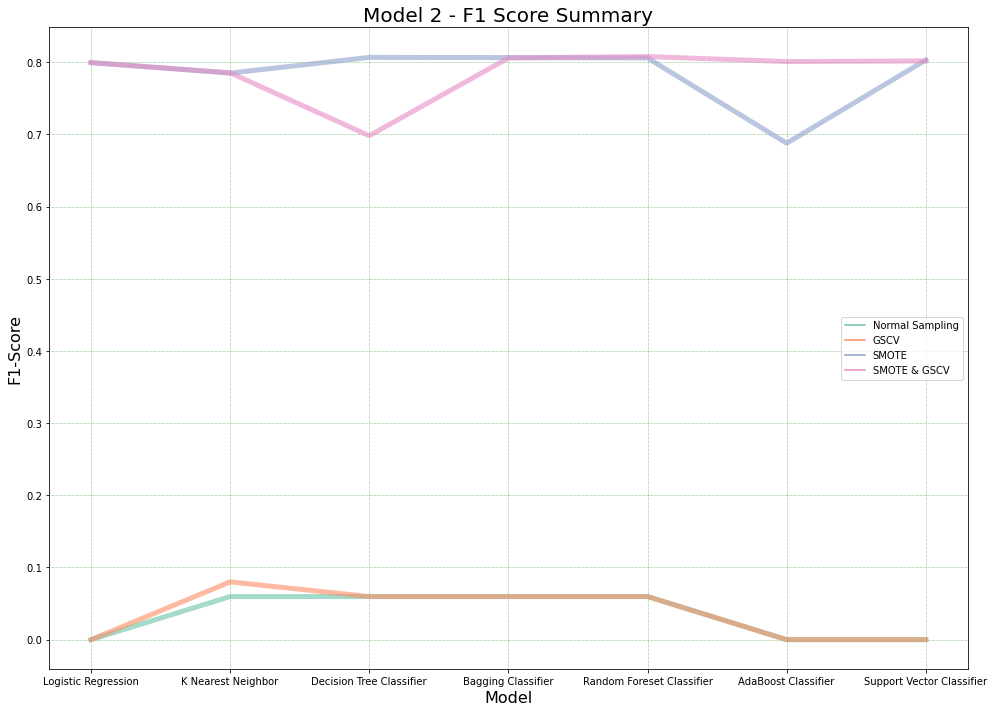

In [191]:
plt.figure(figsize = (14, 10))
sns.lineplot(data=summ_2_plot, x='Model', y="F1 Score", hue="Remark", ci = None, palette = "Set2",  linewidth = 5, alpha = 0.6)
plt.title("Model 2 - F1 Score Summary", fontsize = 20)

plt.grid(color='g', linestyle=':', linewidth=0.5, visible = bool )
plt.legend()
plt.ylabel('F1-Score', fontsize = 16)
plt.xlabel('Model', fontsize = 16)
plt.savefig('./image/m2_score_summary.jpg')
plt.tight_layout()
plt.show()

Inference:

Based on the model performance above, we would be looking at F1-score again due to very unbalanced datasets of 96% vs 4%. Despite performing the feature selection and engineering on removing the features that are not related to cultivating WNV, we still see a badly performed F1-Score on the initial datasets. This shows that the models did not accurately predict the wanted class which is the present of WNV.

With some models has F1-score similar to Base Model, those models will not be considered to going further.

At here, we decided to select the models with SMOTE Oversampling with GridSearchCV. We noticed that the F1-scores for `Bagging Classifier`, `Random Forest Classifier`, `AdaBoost Classifier` and `Support Vector Classifier` are really closed to one another which is 0.80. To further select down to only 1 model, we look at the Train and Test Score of the 4 models. Basing on the Train and Test Score, it seems that Decision Tree Classifier had a better train and test score which shows that the model is able to predict well. Despite the model is slightly overfit, but the scores is quite negligible. 

Thus, `Bagging Classifier` would be used to do the prediction

## Model 2 Prediction

In [192]:
test_m2 = df_test_m2.copy()

In [193]:
# To check on the columns in the datasets
test_m2.columns

Index(['Id', 'Species', 'Trap_T002', 'Trap_T002A', 'Trap_T002B', 'Trap_T003',
       'Trap_T004', 'Trap_T005', 'Trap_T006', 'Trap_T007',
       ...
       'Trap_T232', 'Trap_T233', 'Trap_T234', 'Trap_T235', 'Trap_T236',
       'Trap_T237', 'Trap_T238', 'Trap_T900', 'Trap_T903', 'BreedCond'],
      dtype='object', length=151)

In [194]:
# To drop `Id` and `Species` features from the test set for prediction
test_m2.drop(['Id', 'Species'], axis = 1, inplace = True)

In [195]:
# Standard Scaler the test dataset
test_m2_ss = ss_2.transform(test_m2)

# Model Prediction on Train dataset
test_m2_pred = bagc_2_cv_s.predict(test_m2_ss)

In [196]:
test_m2['WnvPresent'] = test_m2_pred

In [197]:
test_m2['Id'] = df_test_m2['Id']

In [198]:
test_m2.head()

,Trap_T002,Trap_T002A,Trap_T002B,Trap_T003,Trap_T004,Trap_T005,Trap_T006,Trap_T007,Trap_T008,Trap_T009,Trap_T011,Trap_T012,Trap_T013,Trap_T014,Trap_T015,Trap_T016,Trap_T017,Trap_T018,Trap_T019,Trap_T025,Trap_T027,Trap_T028,Trap_T030,Trap_T031,Trap_T033,Trap_T034,Trap_T035,Trap_T036,Trap_T037,Trap_T039,Trap_T040,Trap_T043,Trap_T044,Trap_T045,Trap_T046,Trap_T047,Trap_T048,Trap_T049,Trap_T050,Trap_T051,Trap_T054,Trap_T054C,Trap_T060,Trap_T061,Trap_T062,Trap_T063,Trap_T065,Trap_T065A,Trap_T066,Trap_T067,Trap_T069,Trap_T070,Trap_T071,Trap_T072,Trap_T073,Trap_T074,Trap_T075,Trap_T076,Trap_T077,Trap_T078,Trap_T079,Trap_T080,Trap_T081,Trap_T082,Trap_T083,Trap_T084,Trap_T085,Trap_T086,Trap_T088,Trap_T089,Trap_T090,Trap_T090A,Trap_T090B,Trap_T090C,Trap_T091,Trap_T092,Trap_T094,Trap_T094B,Trap_T095,Trap_T096,Trap_T097,Trap_T099,Trap_T100,Trap_T102,Trap_T103,Trap_T107,Trap_T114,Trap_T115,Trap_T128,Trap_T128A,Trap_T129,Trap_T135,Trap_T138,Trap_T141,Trap_T142,Trap_T143,Trap_T144,Trap_T145,Trap_T146,Trap_T147,Trap_T148,Trap_T149,Trap_T150,Trap_T151,Trap_T152,Trap_T153,Trap_T154,Trap_T155,Trap_T156,Trap_T157,Trap_T158,Trap_T159,Trap_T160,Trap_T161,Trap_T162,Trap_T200,Trap_T200A,Trap_T200B,Trap_T206,Trap_T209,Trap_T212,Trap_T215,Trap_T218,Trap_T218A,Trap_T218B,Trap_T218C,Trap_T219,Trap_T220,Trap_T221,Trap_T222,Trap_T223,Trap_T224,Trap_T225,Trap_T226,Trap_T227,Trap_T228,Trap_T229,Trap_T230,Trap_T231,Trap_T232,Trap_T233,Trap_T234,Trap_T235,Trap_T236,Trap_T237,Trap_T238,Trap_T900,Trap_T903,BreedCond,WnvPresent,Id
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008-06-11,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
2008-06-11,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2
2008-06-11,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3
2008-06-11,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,9
2008-06-11,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,10


# Feature Importance

## Model 1 - Prediction of Breeding Condition for Mosquito

In [199]:
m1_feature = bagc_cv_s.best_estimator_

In [200]:
feature_importances_m1 = np.mean([
    tree.feature_importances_ for tree in m1_feature.estimators_
], axis=0)

In [201]:
feature_names = m1_X.columns
features_1 = pd.DataFrame(np.squeeze(feature_names), columns=['Features']) 

In [202]:
features_1['Coeff'] = feature_importances_m1

In [203]:
feature_m1_t10 = features_1.sort_values(by ='Coeff', ascending = False).head(10)

## Model 2 - Prediction of WNV Present

In [204]:
m2_feature = bagc_2_cv_s.best_estimator_

In [205]:
feature_importances_m2 = np.mean([
    tree.feature_importances_ for tree in m2_feature.estimators_
], axis=0)

In [206]:
feature_names = m2_X.columns
features_2 = pd.DataFrame(np.squeeze(feature_names), columns=['Features']) 

In [207]:
features_2['Coeff'] = feature_importances_m2

In [208]:
feature_m2_t10 = features_2.sort_values(by ='Coeff', ascending = False).head(10)

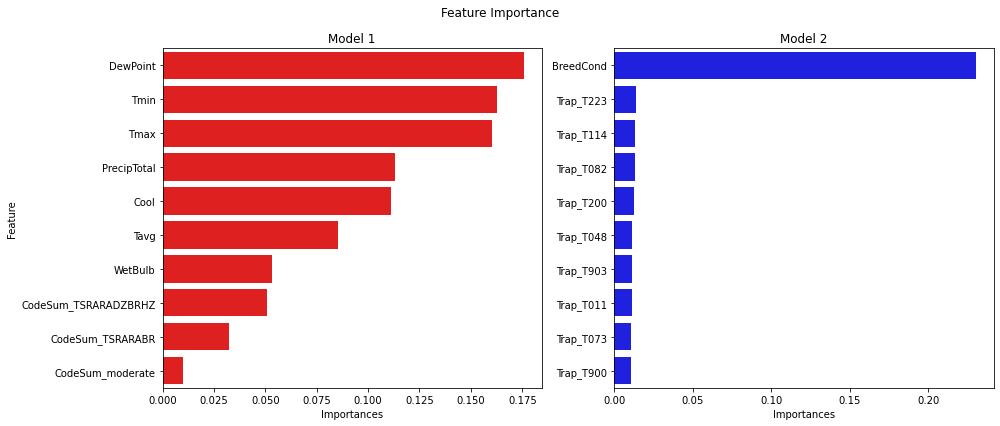

In [224]:
# setting up a subplot to display the top 10 words in each subreddit
fig, ax = plt.subplots(nrows=1,ncols=2,
                       figsize=(14,6),
                       sharex=False,sharey=False
                      )

fig.suptitle('Feature Importance')

# plotting the r/wallstreetbets bar-plot
ax[0].set_title('Model 1')
sns.barplot(ax=ax[0],
            data=feature_m1_t10,
            x='Coeff',
            y='Features',
            color = 'red',
            linewidth=0
           )


# plotting the right (stocks) bar-plot
ax[1].set_title('Model 2')
sns.barplot(ax=ax[1],
            data=feature_m2_t10,
            x='Coeff',
            y='Features',
            color = 'blue'
            ,linewidth=0
           )

# setting the x-label
ax[0].set(xlabel='Importances', ylabel='Feature')
ax[1].set(xlabel='Importances', ylabel='')


plt.savefig('./image/feature_importance.jpg')
plt.tight_layout()

Inference:

In model 1 where prediciton of Breeding Condition of Mosquito, we could see `DewPoint`, `Tmin`, `Tmax`, `PrecipTotal`, `Cool`, `Tavg` & `WetBulb` are the importance features we see in Model 1. We could imply that these weather parameters are highly related in contributing for breeding mosquitos.

As for Model 2, seems like Breeding Condition is the main reason why WNV present. Traps are also shown in the Top 10 features but the scores are relatively lower compared with Breeding Condition. We could see top 9 traps that have higher importance in having WNV. These could be the target for spray.

From these 2 models, we could conclude that weather is an importance factors in contributing WNV. We are see some 9 traps stated here and these could be the locations with higher WNV. 

# Test Datasets Adjustment

In [210]:
# Cross check on the rows for both original test and predicted test set
print(df_test.shape)
print(test_m2.shape)

(116293, 27)
(38869, 151)


In [211]:
test_m2['WnvPresent'].value_counts()

1    24158
0    14711
Name: WnvPresent, dtype: int64

In [212]:
# Identify the ID that are not present in the predicted set
ori_test_diff = list(set(df_test['Id']).difference(set(test_m2['Id'])))
len(ori_test_diff)

77424

In [213]:
# merging the datasets from the original test set to the prediction
final_test = pd.merge(df_test, test_m2[['Id', 'WnvPresent', 'BreedCond']], on = 'Id', how = 'left').set_axis(df_test.index)

print(final_test.shape)

(116293, 29)


In [214]:
# Identify if there is any null values
final_test['WnvPresent'].isnull().sum()

77424

In [215]:
# to replace the null values with 0 as these are the rows that are deemend to be not carrying WNV
final_test['WnvPresent'].replace(np.nan, '0', inplace = True)

# To convert the feature to integer
final_test['WnvPresent'] = final_test['WnvPresent'].astype(int)

In [216]:
submission = final_test[['Id','WnvPresent']]

In [217]:
submission.to_csv('./assets/submission_221027.csv', index=False)

In [218]:
submission['WnvPresent'].value_counts()

0    92135
1    24158
Name: WnvPresent, dtype: int64

# Exporting Combined Datasets

In [219]:
# To set date as index for train datset
train['Date'] = pd.to_datetime(train['Date'])
train = train.set_index('Date')

In [220]:
# to set the BreedCondition threshold
train['BreedCond'] = train['NumMosquitos'].apply(lambda x: 1 if x >= 13 else 0)

In [221]:
# To extract the rows of data from both original train and test with prediction
train_for_merge = train[['Species', 'Trap', 'Latitude', 'Longitude','WnvPresent','BreedCond']]
test_for_merge = final_test[['Species', 'Trap', 'Latitude', 'Longitude','WnvPresent','BreedCond']]

In [222]:
# To Merge both train and test datasets
df_merged = pd.concat([train_for_merge, test_for_merge])

In [223]:
df_merged.to_csv('./assets/df_merged.csv', index=False)